# Import Library

In [2]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np 
#
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_excel('/content/drive/MyDrive/Data/SalesData.xlsx')

In [5]:
# DataSet의 Columns Name 변경
df.columns = ['Date', 'Sales', 'NetSales', 'Amount', 'MeanSales', 'DiscountRate', 'Stores', 'SKU']
# 기본 7 Columns 변수 할당
dflst = ['Sales', 'NetSales', 'MeanSales', 'Amount', 'DiscountRate', 'Stores', 'SKU']
# DataFrame 출력 format 설정_ 과학적 표기법 사용X
pd.options.display.float_format = '{:.2f}'.format
df.head()

,Date,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,5560000,5522100,41,135609.76,0.01,48,7


In [6]:
df['Day'] = 'temp'
tlst = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

for i in range(len(df)):
  df['Day'][i+4] = tlst[i%7]

for i in range(4):
  df['Day'][i] = tlst[i+3]

df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU,Day
0,2017-06-01,2502000,2383400,18,139000.00,0.05,48,4,Thur
1,2017-06-02,6086000,5984800,45,135244.44,0.02,48,8,Fri
2,2017-06-03,12778000,12510600,92,138891.30,0.02,48,8,Sat
3,2017-06-04,10842000,10631400,78,139000.00,0.02,48,7,Sun
4,2017-06-05,5560000,5522100,41,135609.76,0.01,48,7,Mon
...,...,...,...,...,...,...,...,...,...
939,2019-12-27,3755000,3432600,25,150200.00,0.09,42,13,Fri
940,2019-12-28,7799000,7174700,52,149980.77,0.08,42,17,Sat
941,2019-12-29,11227900,10488900,75,149705.33,0.07,42,19,Sun
942,2019-12-30,5672000,5313000,38,149263.16,0.06,42,16,Mon


In [6]:
#Date column YY-MM-DD 분할 Column 생성
df['YY'] = 'temp'
df['MM'] = 'temp'
df['DD'] = 'temp'
for i in range(len(df)):
  tstr = df.iloc[i]['Date']
  [yy, mm, dd] = str(tstr).split("-")
  dd = dd.split(" ")[0]
  df['YY'].iloc[i] = yy
  df['MM'].iloc[i] = mm
  df['DD'].iloc[i] = dd

df = df[['Date', 'YY', 'MM', 'DD', 'Day', 'Sales', 'NetSales', 'Amount', 'MeanSales', 'DiscountRate', 'Stores', 'SKU']]
df

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Date,YY,MM,DD,Day,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2017,06,01,Thur,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,2017,06,02,Fri,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,2017,06,03,Sat,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,2017,06,04,Sun,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,2017,06,05,Mon,5560000,5522100,41,135609.76,0.01,48,7
...,...,...,...,...,...,...,...,...,...,...,...,...
939,2019-12-27,2019,12,27,Fri,3755000,3432600,25,150200.00,0.09,42,13
940,2019-12-28,2019,12,28,Sat,7799000,7174700,52,149980.77,0.08,42,17
941,2019-12-29,2019,12,29,Sun,11227900,10488900,75,149705.33,0.07,42,19
942,2019-12-30,2019,12,30,Mon,5672000,5313000,38,149263.16,0.06,42,16


# 2021-01-18 


## Dataset 속성 파악

### 기술통계

In [ ]:
df.describe()

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,944.00,944.00,944.00,944.00,944.00,944.00,944.00
mean,8407918.43,7658885.36,57.44,147049.30,0.09,45.87,13.03
std,4959462.28,4504263.47,34.17,9739.52,0.08,5.94,4.42
min,219000.00,163400.00,1.00,124250.00,0.00,28.00,2.00
25%,4998750.00,4525550.00,34.00,139000.00,0.04,45.00,10.00
50%,7057500.00,6462550.00,48.00,144814.89,0.07,46.00,13.00
75%,10891250.00,10195725.00,75.00,152967.27,0.13,49.00,16.00
max,37391000.00,25800000.00,269.00,219000.00,0.65,56.00,30.00


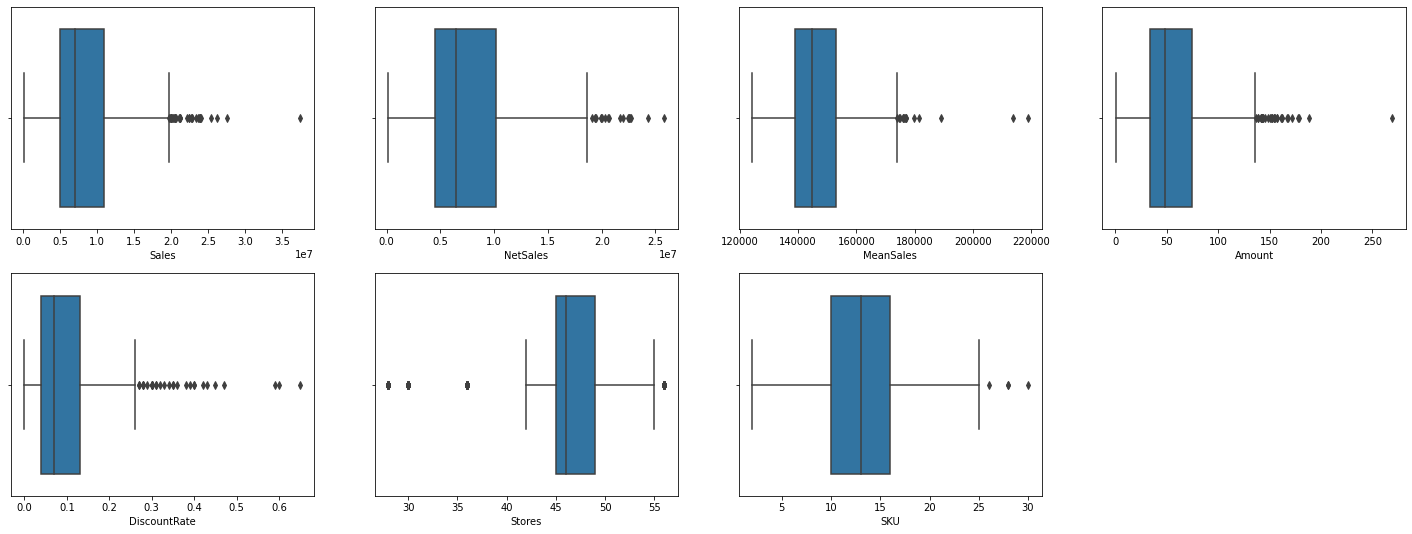

In [ ]:
i = 1
plt.figure(figsize=(25,9))
for tempcol in dflst:
  plt.subplot(2,4,i)
  sns.boxplot(data=df, x=tempcol)
  i = i+1

plt.show()

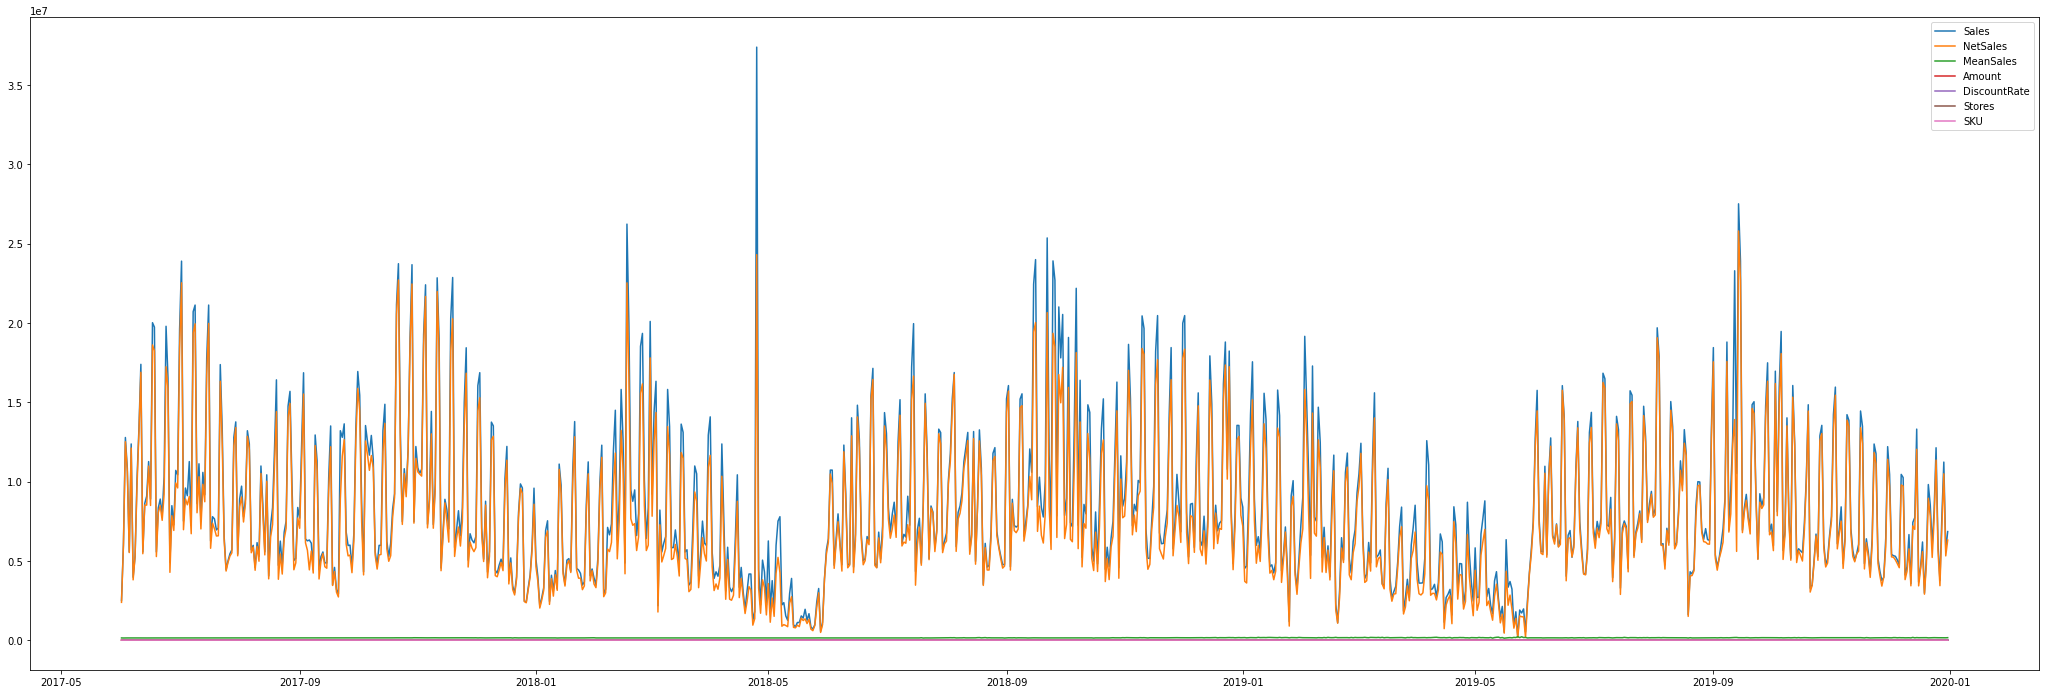

In [ ]:
# 기간동안의 Column 별 전체 추세 확인
fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot()
for i in range(len(dflst)):
  ax.plot(df['Date'], df[dflst[i]], label=dflst[i])

ax.legend()
plt.show()

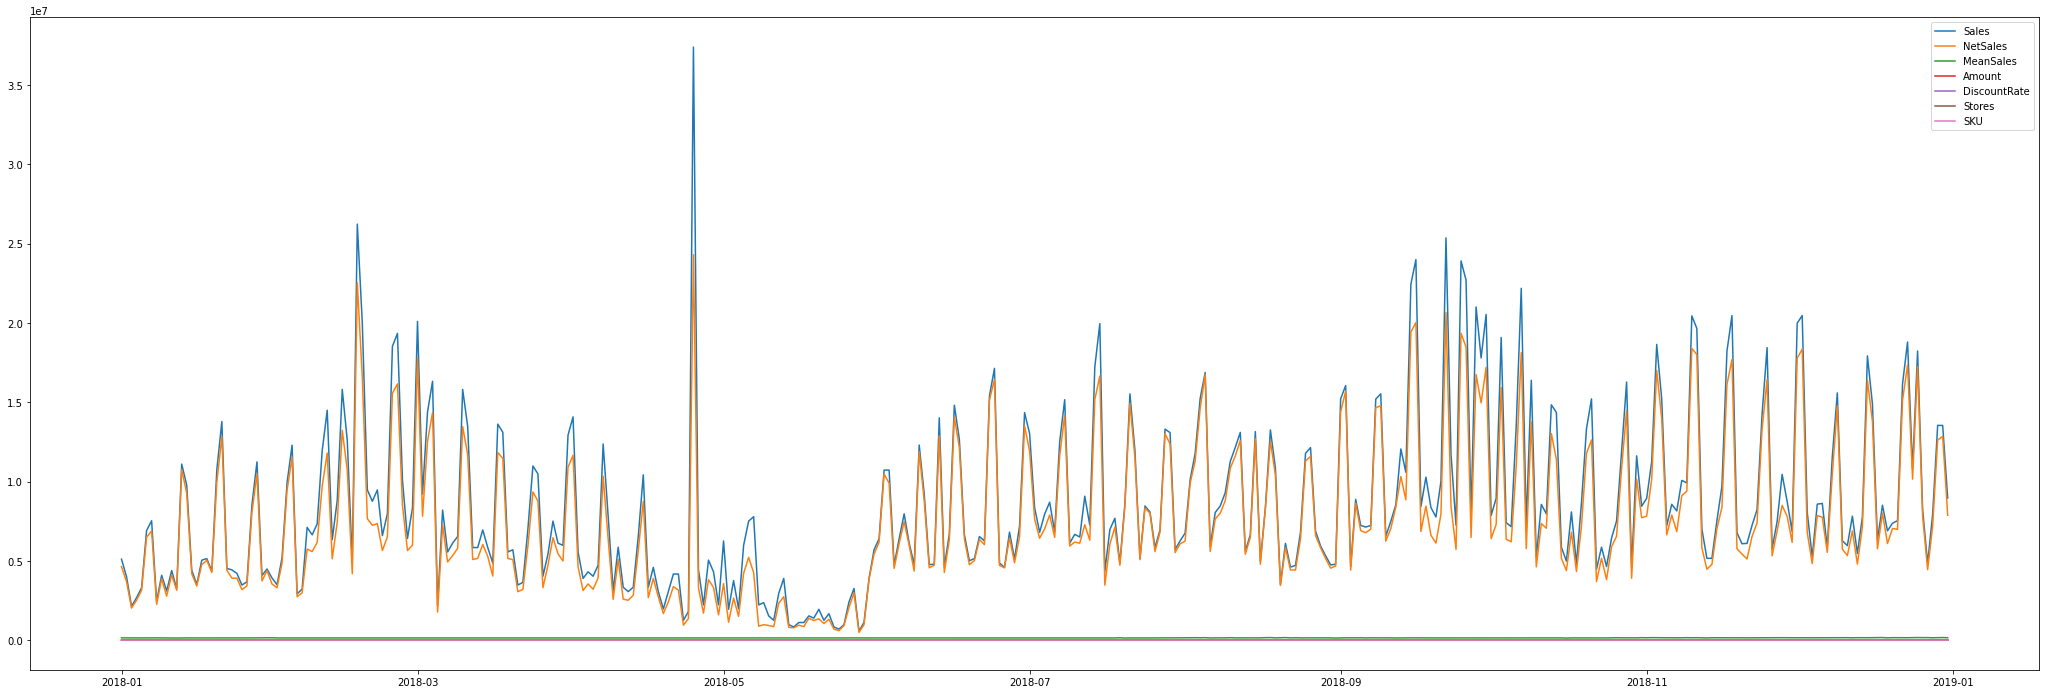

In [ ]:
# 기간동안의 Column 별 전체 추세 확인(연도별 분할_2017)
tpdf = df.loc[df["YY"]=='2018']
fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot()
for i in range(len(dflst)):
  ax.plot(tpdf['Date'], tpdf[dflst[i]], label=dflst[i])

ax.legend()
plt.show()

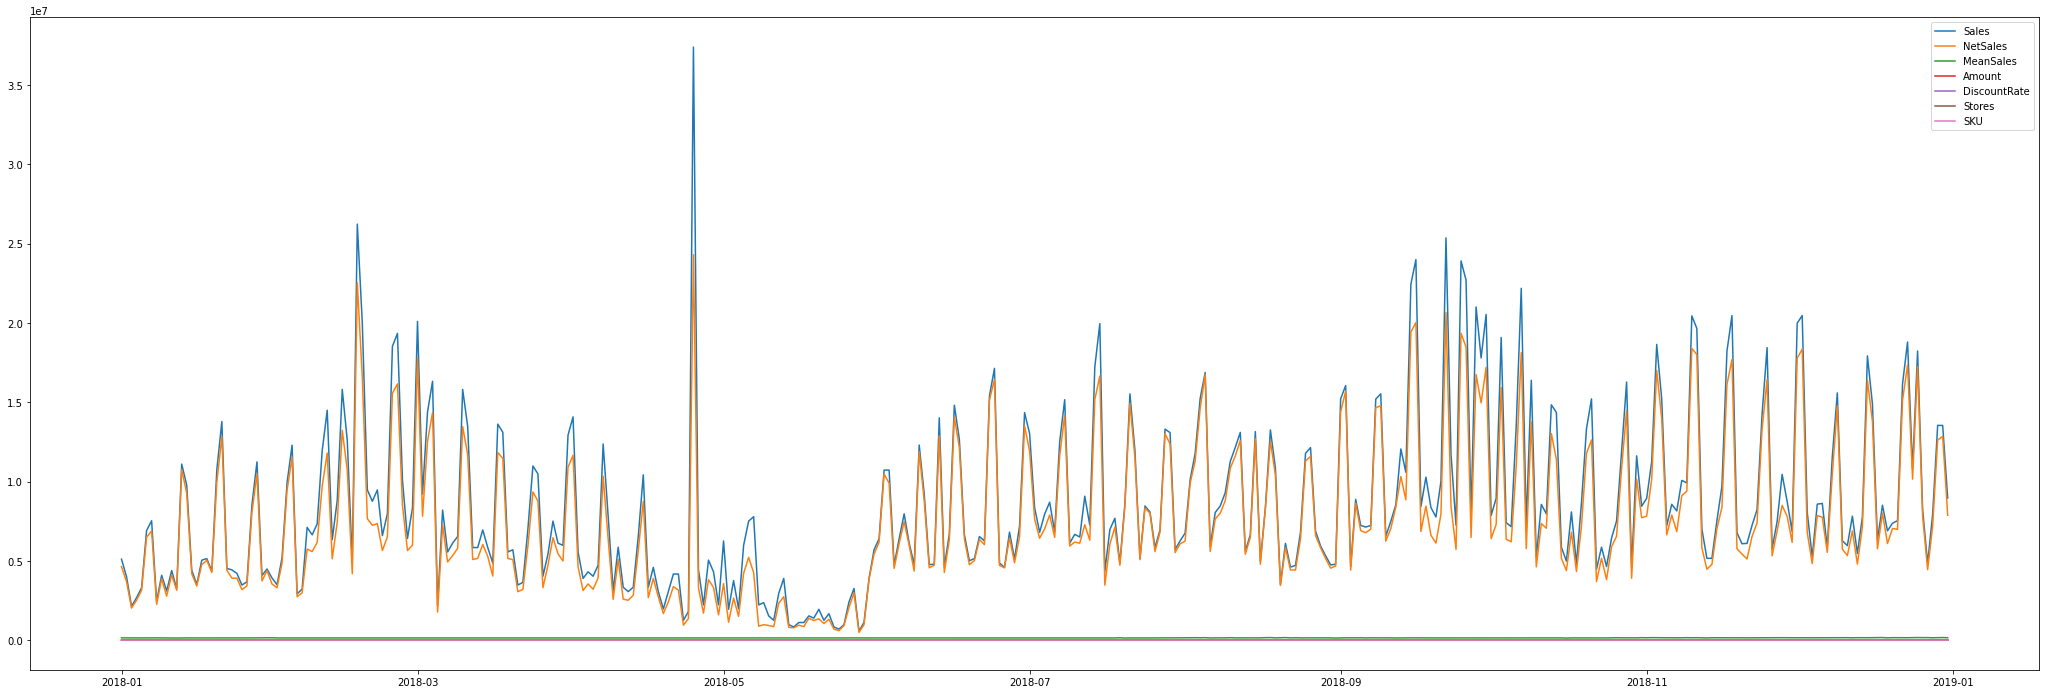

In [ ]:
tpdf = df.loc[df["YY"]=='2018']
fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot()
for i in range(len(dflst)):
  ax.plot(tpdf['Date'], tpdf[dflst[i]], label=dflst[i])

ax.legend()
plt.show()

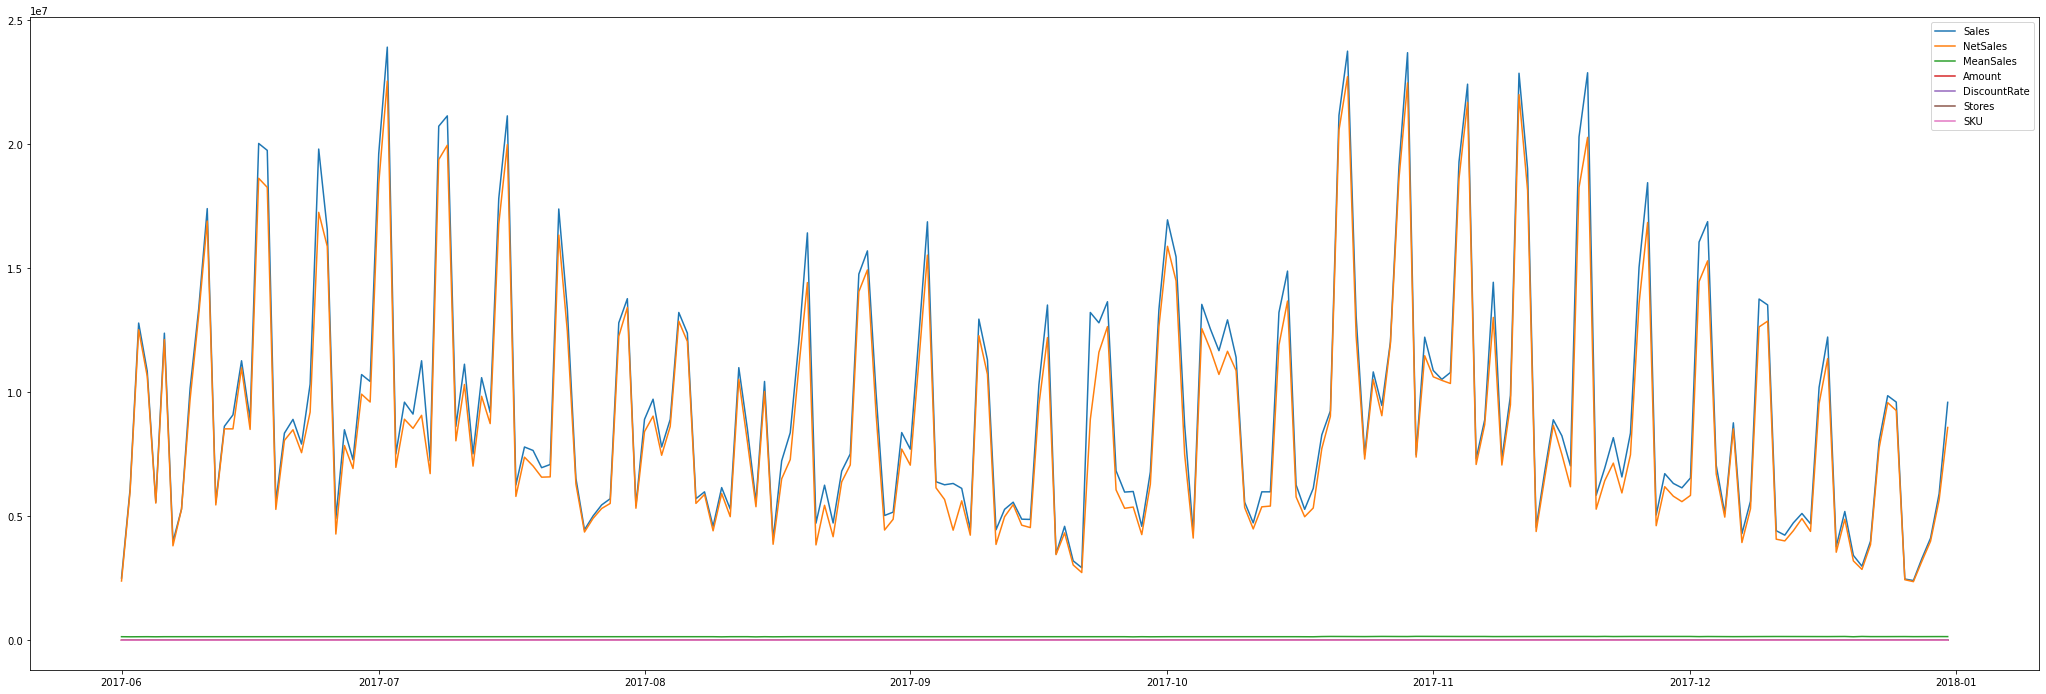

In [ ]:
tpdf = df.loc[df["YY"]=='2017']
fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot()
for i in range(len(dflst)):
  ax.plot(tpdf['Date'], tpdf[dflst[i]], label=dflst[i])

ax.legend()
plt.show()

### 변수간 상관관계 분석

In [ ]:
tempdf = df[['Sales', 'NetSales', 'Amount', 'MeanSales', 'DiscountRate', 'Stores', 'SKU']]
tempdf

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2502000,2383400,18,139000.00,0.05,48,4
1,6086000,5984800,45,135244.44,0.02,48,8
2,12778000,12510600,92,138891.30,0.02,48,8
3,10842000,10631400,78,139000.00,0.02,48,7
4,5560000,5522100,41,135609.76,0.01,48,7
...,...,...,...,...,...,...,...
939,3755000,3432600,25,150200.00,0.09,42,13
940,7799000,7174700,52,149980.77,0.08,42,17
941,11227900,10488900,75,149705.33,0.07,42,19
942,5672000,5313000,38,149263.16,0.06,42,16


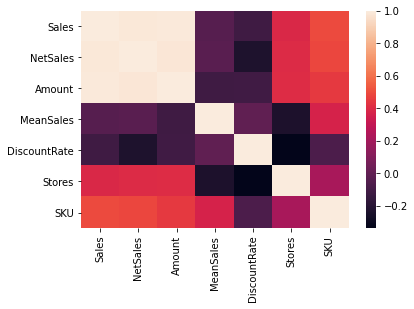

In [ ]:
%matplotlib inline
sns.heatmap(df.corr())
plt.show()

### 연도별 Sales Value 기술통계

In [ ]:
df.loc[df['YY']=='2017'].describe()

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,214.00,214.00,214.00,214.00,214.00,214.00,214.00
mean,9570067.76,8955224.77,67.72,141101.54,0.06,47.98,9.69
std,5018895.08,4713668.44,35.10,4120.43,0.04,2.68,2.13
min,2403000.00,2357200.00,17.00,132642.86,0.00,43.00,4.00
25%,5699000.00,5365675.00,41.00,139000.00,0.04,46.00,8.00
50%,8342000.00,7627250.00,58.50,139000.00,0.06,48.00,10.00
75%,12371000.00,11630925.00,89.00,144081.63,0.08,50.00,11.00
max,23898000.00,22708600.00,172.00,152469.39,0.33,52.00,17.00


In [ ]:
df.loc[df['YY']=='2018'].describe()

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,365.00,365.00,365.00,365.00,365.00,365.00,365.00
mean,8530174.25,7567555.01,59.45,142835.28,0.12,46.68,13.15
std,5320772.38,4610200.81,36.84,6287.28,0.08,7.02,4.79
min,556000.00,486500.00,4.00,131131.58,0.00,28.00,2.00
25%,4830000.00,4424200.00,34.00,139000.00,0.05,45.00,10.00
50%,7212000.00,6392500.00,50.00,140052.63,0.10,47.00,13.00
75%,11249000.00,10319400.00,77.00,145557.38,0.16,49.00,16.00
max,37391000.00,24305580.00,269.00,164225.23,0.60,56.00,28.00


In [ ]:
df.loc[df['YY']=='2019'].describe()

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,365.00,365.00,365.00,365.00,365.00,365.00,365.00
mean,7604292.88,6990170.14,49.40,154750.50,0.09,43.81,14.87
std,4383312.22,4106094.61,28.55,9909.82,0.08,5.52,3.88
min,219000.00,163400.00,1.00,124250.00,0.00,30.00,4.00
25%,4668000.00,4169800.00,30.00,148705.88,0.04,42.00,12.00
50%,6459000.00,6048600.00,43.00,153651.16,0.07,45.00,15.00
75%,9379000.00,8743800.00,61.00,159444.44,0.12,46.00,17.00
max,27512000.00,25800000.00,178.00,219000.00,0.65,50.00,30.00


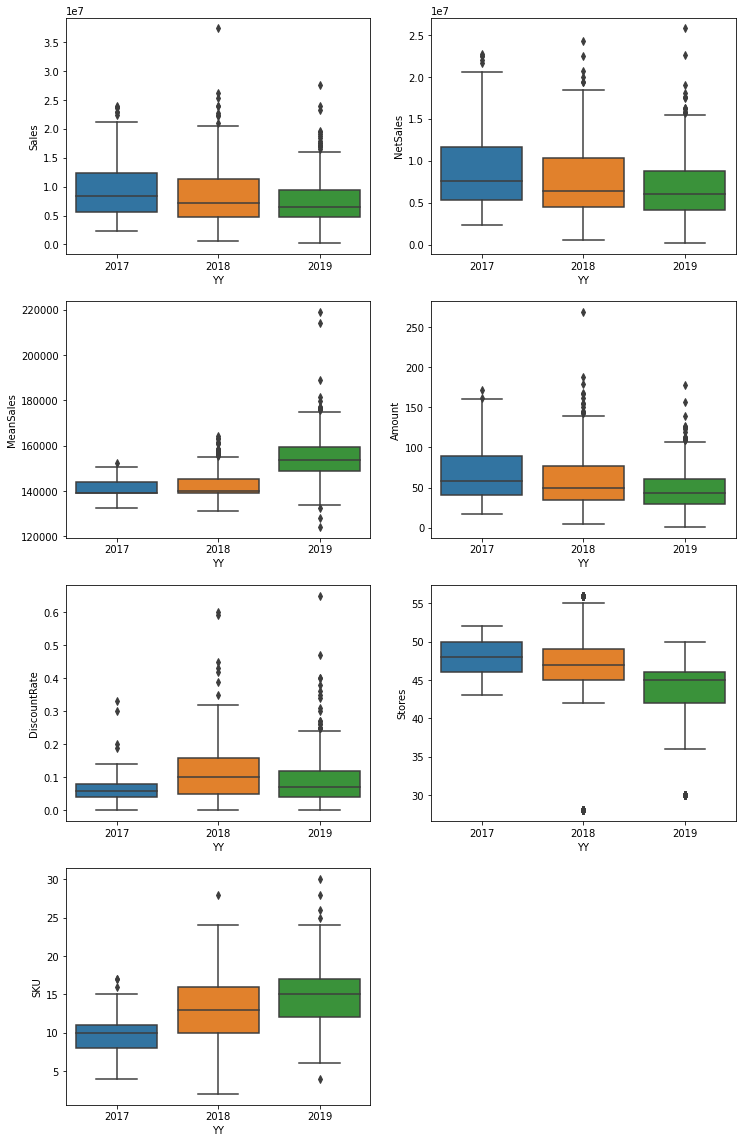

In [ ]:
plt.figure(figsize=(12,20))
for i in range(len(dflst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, x='YY', y=dflst[i])

plt.show()

### 월별 Sales Value 기술통계

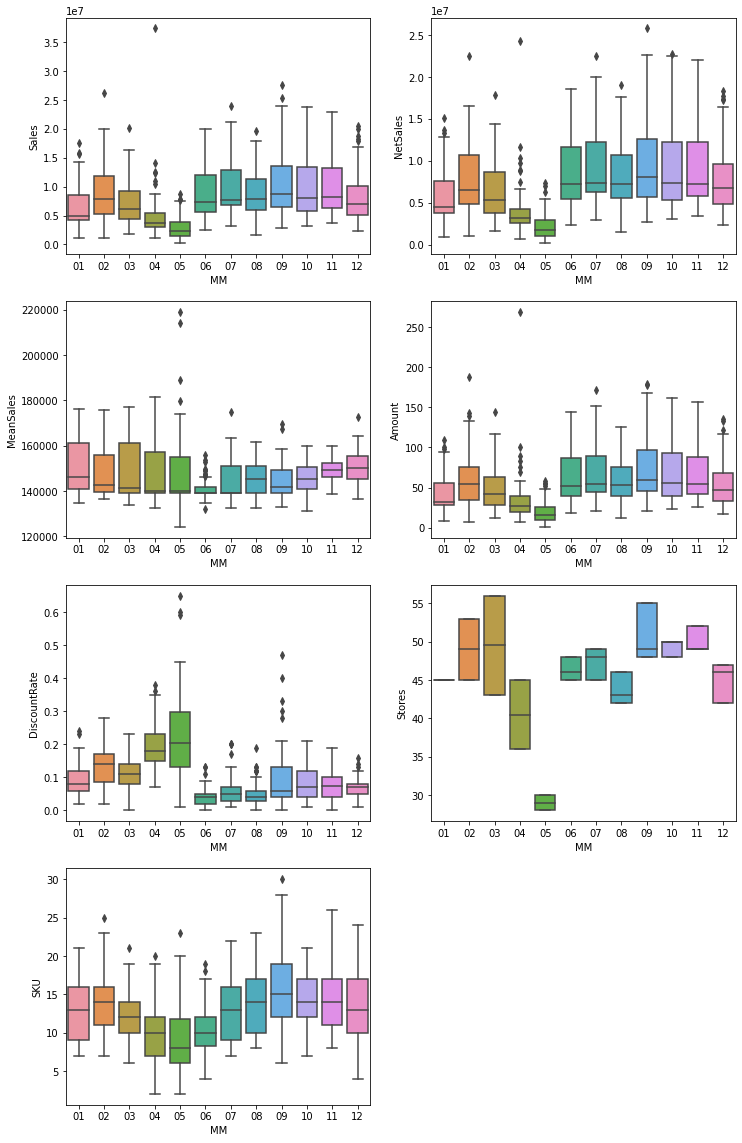

In [ ]:
plt.figure(figsize=(12, 20))
for i in range(len(dflst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, y=dflst[i], x="MM", order=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

plt.show()

### 일별 Sales Value 기술통계

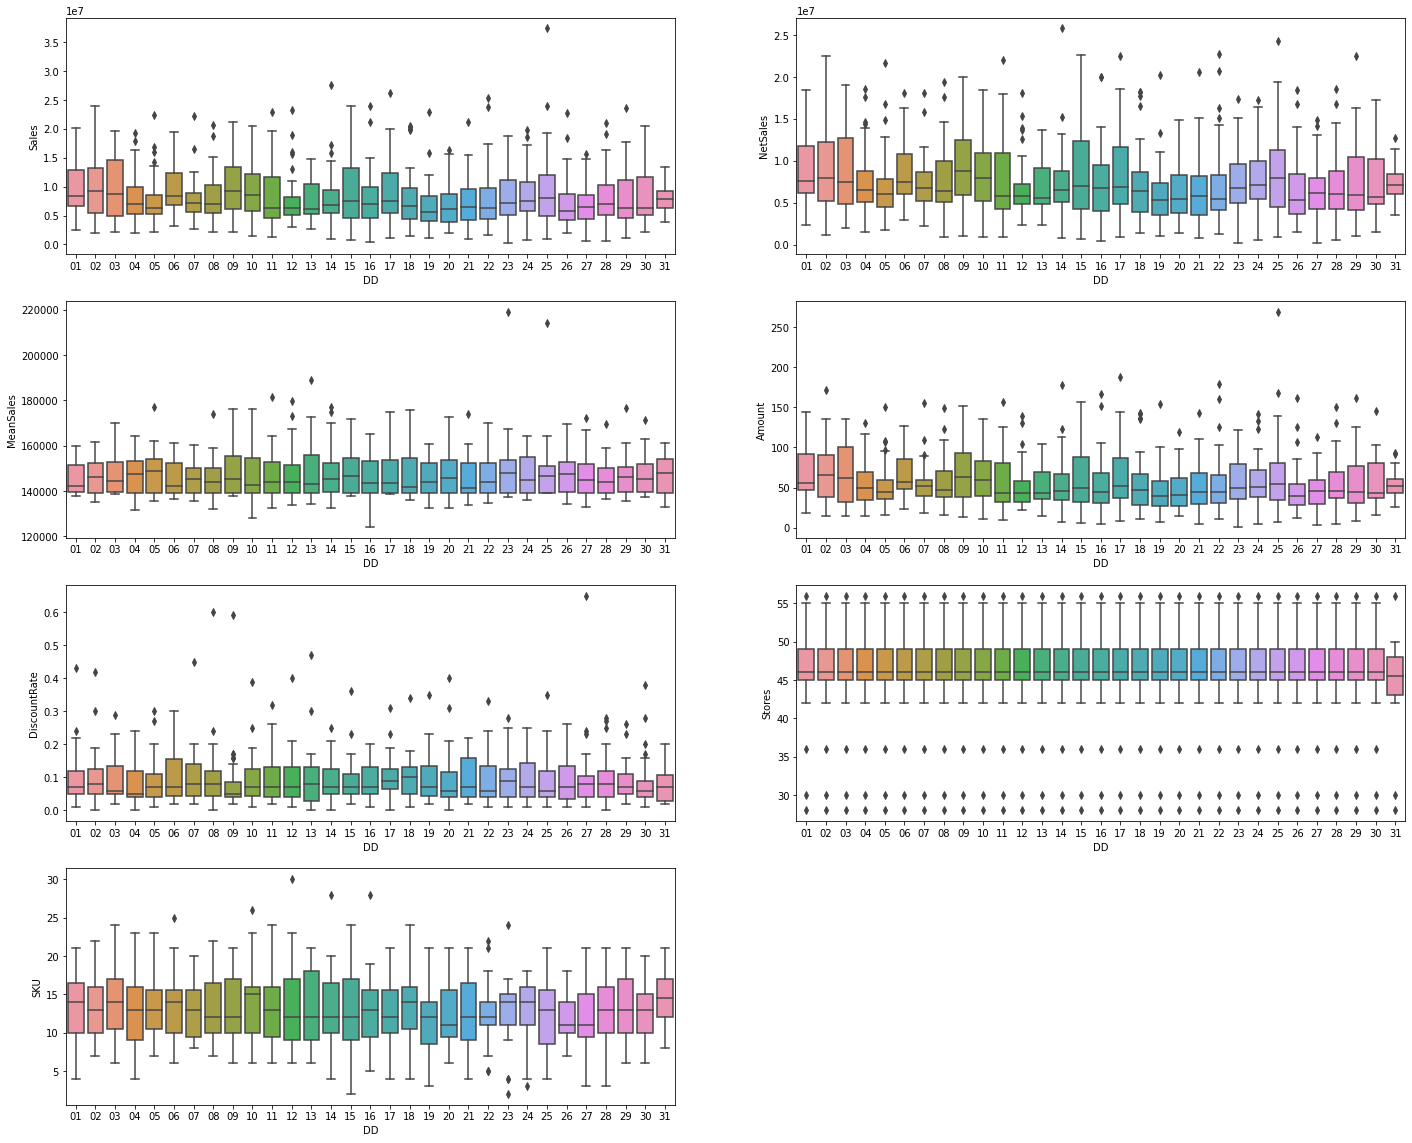

In [ ]:
plt.figure(figsize=(24,20))
for i in range(len(dflst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, y=dflst[i], x='DD')

plt.show()

### 요일별 분리

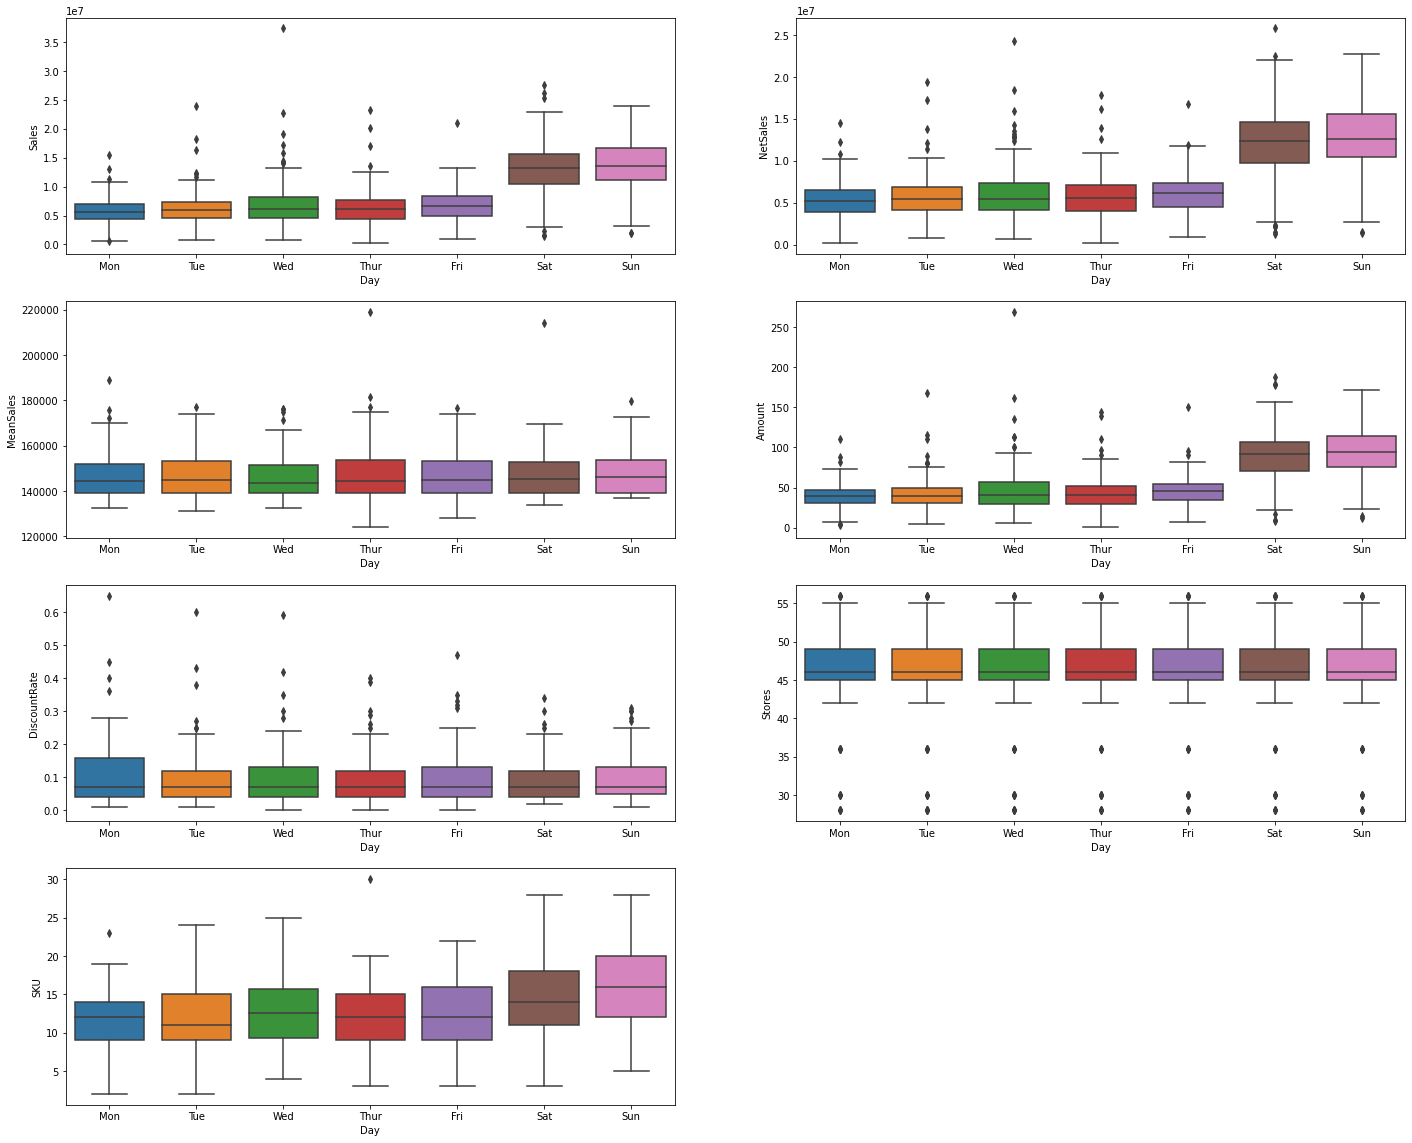

In [ ]:
plt.figure(figsize=(24,20))
for i in range(len(dflst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, y=dflst[i], x='Day', order=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

plt.show()

In [ ]:
df

,Date,YY,MM,DD,Day,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2017,06,01,Thur,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,2017,06,02,Fri,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,2017,06,03,Sat,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,2017,06,04,Sun,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,2017,06,05,Mon,5560000,5522100,41,135609.76,0.01,48,7
...,...,...,...,...,...,...,...,...,...,...,...,...
939,2019-12-27,2019,12,27,Fri,3755000,3432600,25,150200.00,0.09,42,13
940,2019-12-28,2019,12,28,Sat,7799000,7174700,52,149980.77,0.08,42,17
941,2019-12-29,2019,12,29,Sun,11227900,10488900,75,149705.33,0.07,42,19
942,2019-12-30,2019,12,30,Mon,5672000,5313000,38,149263.16,0.06,42,16


### 연도별 분리

In [ ]:
tmpdf = df.copy()
tmpdf['MMDD'] = 'temp'
for i in range(len(tmpdf)):
  tmpdf['MMDD'].iloc[i] = str(tmpdf.iloc[i]['MM'])+'-'+str(tmpdf.iloc[i]['DD'])

tmpdf

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Date,YY,MM,DD,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU,MMDD
0,2017-06-01,2017,06,01,2502000,2383400,18,139000.00,0.05,48,4,06-01
1,2017-06-02,2017,06,02,6086000,5984800,45,135244.44,0.02,48,8,06-02
2,2017-06-03,2017,06,03,12778000,12510600,92,138891.30,0.02,48,8,06-03
3,2017-06-04,2017,06,04,10842000,10631400,78,139000.00,0.02,48,7,06-04
4,2017-06-05,2017,06,05,5560000,5522100,41,135609.76,0.01,48,7,06-05
...,...,...,...,...,...,...,...,...,...,...,...,...
939,2019-12-27,2019,12,27,3755000,3432600,25,150200.00,0.09,42,13,12-27
940,2019-12-28,2019,12,28,7799000,7174700,52,149980.77,0.08,42,17,12-28
941,2019-12-29,2019,12,29,11227900,10488900,75,149705.33,0.07,42,19,12-29
942,2019-12-30,2019,12,30,5672000,5313000,38,149263.16,0.06,42,16,12-30


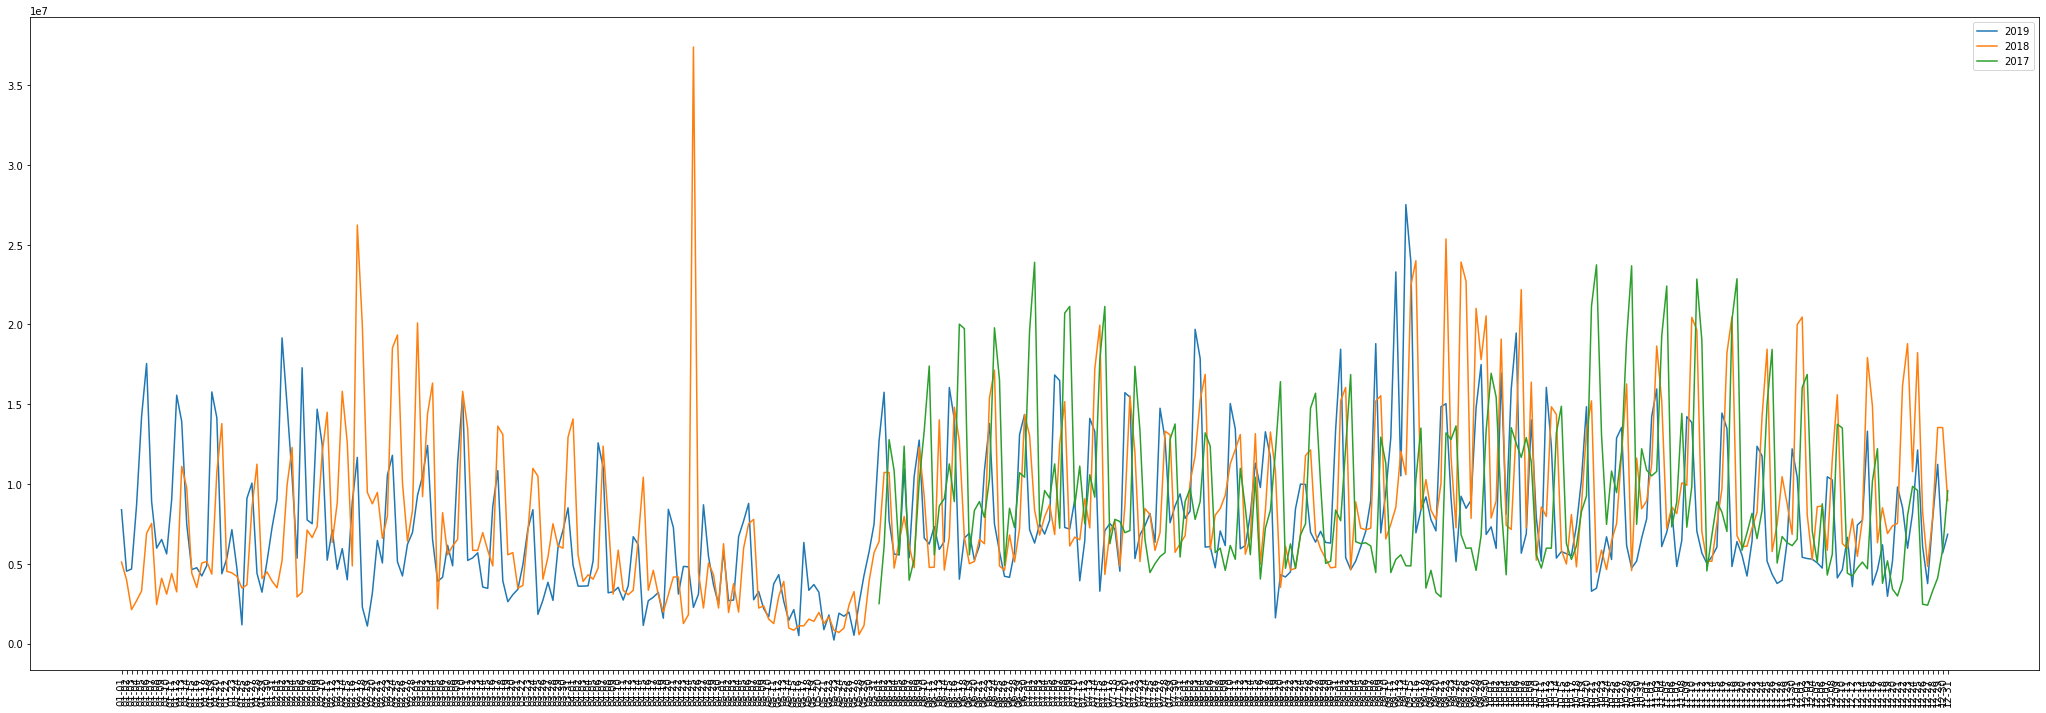

In [ ]:
fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot()

ax.plot(tmpdf.loc[tmpdf['YY']=='2019']['MMDD'], tmpdf.loc[df['YY']=='2019']['Sales'], label=2019)
ax.plot(tmpdf.loc[tmpdf['YY']=='2018']['MMDD'], tmpdf.loc[df['YY']=='2018']['Sales'], label=2018)
ax.plot(tmpdf.loc[tmpdf['YY']=='2017']['MMDD'], tmpdf.loc[df['YY']=='2017']['Sales'], label=2017)
plt.xticks(rotation = 90)
ax.legend()

plt.show()

# 2021-01-19

## ARIMA

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA 

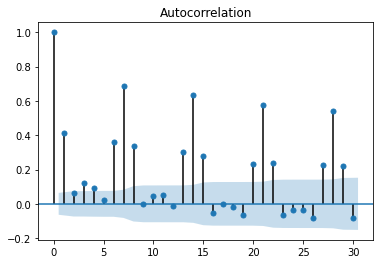

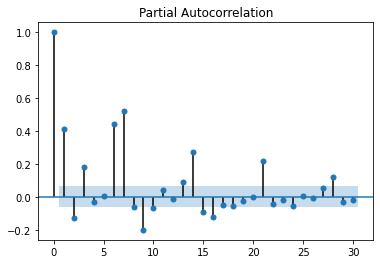

In [ ]:
series = df['Sales']
plot_acf(series)
plot_pacf(series)

plt.show()

In [ ]:
tempdf = df.copy()
tempdf = tempdf[:-31]

In [ ]:
# 1차 차분을 위한 timestamp 진행
tempdf['Sales_{}'.format(1)] = tempdf['Sales'].shift(1)
tempdf

,Date,YY,MM,DD,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU,Sales_1
0,2017-06-01,2017,06,01,2502000,2383400,18,139000.00,0.05,48,4,nan
1,2017-06-02,2017,06,02,6086000,5984800,45,135244.44,0.02,48,8,2502000.00
2,2017-06-03,2017,06,03,12778000,12510600,92,138891.30,0.02,48,8,6086000.00
3,2017-06-04,2017,06,04,10842000,10631400,78,139000.00,0.02,48,7,12778000.00
4,2017-06-05,2017,06,05,5560000,5522100,41,135609.76,0.01,48,7,10842000.00
...,...,...,...,...,...,...,...,...,...,...,...,...
908,2019-11-26,2019,11,26,4341000,4063900,29,149689.66,0.06,49,10,5160700.00
909,2019-11-27,2019,11,27,3765000,3407800,26,144807.69,0.09,49,11,4341000.00
910,2019-11-28,2019,11,28,3964000,3976600,26,152461.54,0.00,49,12,3765000.00
911,2019-11-29,2019,11,29,6399000,5861800,41,156073.17,0.08,49,15,3964000.00


In [ ]:
tempdf = tempdf[['Sales', 'Sales_1']]
tempdf['dif'] = 'temp'
for i in range(len(tempdf)-1):
  tempdf['dif'].loc[i+1] = tempdf['Sales_1'][i+1] - tempdf['Sales'][i+1]

tempdf = tempdf.dropna()
tempdf['dif'] = tempdf['dif'].astype('int')
tempdf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  afte

,Sales,Sales_1,dif
1,6086000,2502000.00,-3584000
2,12778000,6086000.00,-6692000
3,10842000,12778000.00,1936000
4,5560000,10842000.00,5282000
5,12371000,5560000.00,-6811000
...,...,...,...
908,4341000,5160700.00,819700
909,3765000,4341000.00,576000
910,3964000,3765000.00,-199000
911,6399000,3964000.00,-2435000


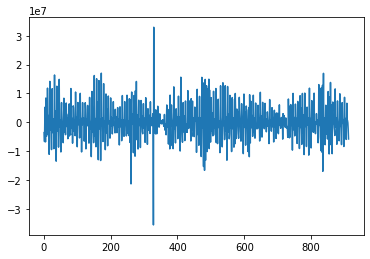

In [ ]:
plt.plot(tempdf['dif'])
plt.show()

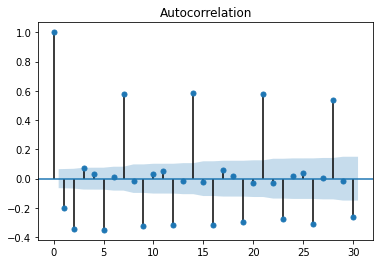

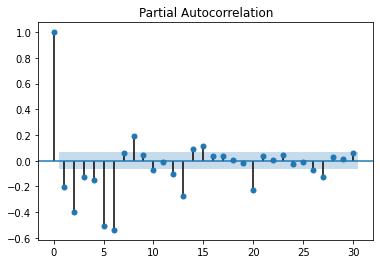

In [ ]:
series = tempdf['dif']
plot_acf(series)
plot_pacf(series)

plt.show()

In [ ]:
#2차 차분을 위한 timestamp 진행
tempdf = df.copy()
tempdf = tempdf[:-31]
tempdf['Sales_{}'.format(2)] = tempdf['Sales'].shift(2)

tempdf = tempdf[['Sales', 'Sales_2']]
tempdf['dif'] = 'temp'
for i in range(len(tempdf)-2):
  tempdf['dif'].loc[i+2] = tempdf['Sales_2'][i+2] - tempdf['Sales'][i+2]

tempdf = tempdf.dropna()
tempdf['dif'] = tempdf['dif'].astype('int')
tempdf

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Sales,Sales_2,dif
2,12778000,2502000.00,-10276000
3,10842000,6086000.00,-4756000
4,5560000,12778000.00,7218000
5,12371000,10842000.00,-1529000
6,3967500,5560000.00,1592500
...,...,...,...
908,4341000,11751000.00,7410000
909,3765000,5160700.00,1395700
910,3964000,4341000.00,377000
911,6399000,3765000.00,-2634000


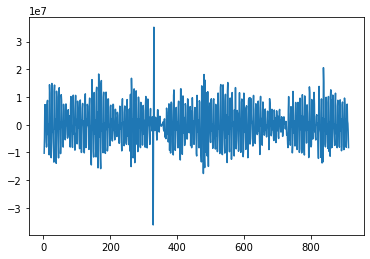

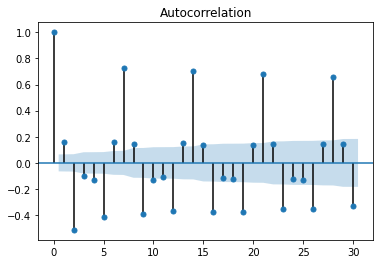

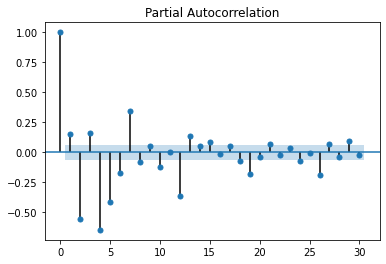

In [ ]:
plt.plot(tempdf['dif'])
series = tempdf['dif']
plot_acf(series)
plot_pacf(series)

plt.show()

In [ ]:
model = ARIMA(series, order=(0,1,1))
model_fit = model.fit(trend='nc', full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.dif   No. Observations:                  911
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -15421.864
Method:                       css-mle   S.D. of innovations        5421204.184
Date:                Wed, 20 Jan 2021   AIC                          30847.729
Time:                        14:10:42   BIC                          30857.358
Sample:                             1   HQIC                         30851.405
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ma.L1.D.dif    -1.0000      0.003   -370.812      0.000      -1.005      -0.995
                                    Roots                                    
                  Real          Imaginary         

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


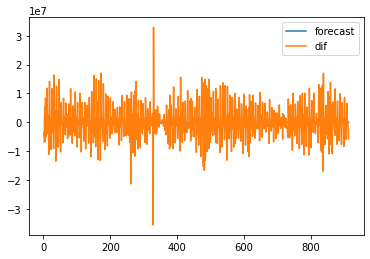

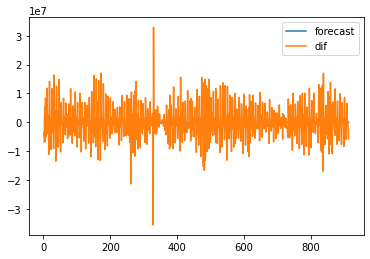

In [ ]:
model_fit.plot_predict()

In [ ]:
fore = model_fit.forecast(steps=1)
print(fore)

(array([-4356.56232562]), array([5421204.18443279]), array([[-10629721.51665173,  10621008.39200049]]))


In [ ]:
tempdf

,Sales,Sales_1,dif
1,6086000,2502000.00,-3584000
2,12778000,6086000.00,-6692000
3,10842000,12778000.00,1936000
4,5560000,10842000.00,5282000
5,12371000,5560000.00,-6811000
...,...,...,...
908,4341000,5160700.00,819700
909,3765000,4341000.00,576000
910,3964000,3765000.00,-199000
911,6399000,3964000.00,-2435000


In [ ]:
df.loc[911:915]

,Date,YY,MM,DD,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
911,2019-11-29,2019,11,29,6399000,5861800,41,156073.17,0.08,49,15
912,2019-11-30,2019,11,30,12200000,11402500,80,152500.00,0.07,49,16
913,2019-12-01,2019,12,01,10442000,9677500,68,153558.82,0.07,42,16
914,2019-12-02,2019,12,02,5405700,5249700,37,146100.00,0.03,42,12
915,2019-12-03,2019,12,03,5327000,5229700,33,161424.24,0.02,42,14


# 2021-01-20

## LSTM

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import mean_squared_error 

In [150]:
df

,Date,YY,MM,DD,Day,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2017,06,01,Thur,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,2017,06,02,Fri,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,2017,06,03,Sat,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,2017,06,04,Sun,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,2017,06,05,Mon,5560000,5522100,41,135609.76,0.01,48,7
...,...,...,...,...,...,...,...,...,...,...,...,...
939,2019-12-27,2019,12,27,Fri,3755000,3432600,25,150200.00,0.09,42,13
940,2019-12-28,2019,12,28,Sat,7799000,7174700,52,149980.77,0.08,42,17
941,2019-12-29,2019,12,29,Sun,11227900,10488900,75,149705.33,0.07,42,19
942,2019-12-30,2019,12,30,Mon,5672000,5313000,38,149263.16,0.06,42,16


### Sales

In [151]:
copydf = df.copy()
copydf

,Date,YY,MM,DD,Day,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2017,06,01,Thur,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,2017,06,02,Fri,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,2017,06,03,Sat,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,2017,06,04,Sun,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,2017,06,05,Mon,5560000,5522100,41,135609.76,0.01,48,7
...,...,...,...,...,...,...,...,...,...,...,...,...
939,2019-12-27,2019,12,27,Fri,3755000,3432600,25,150200.00,0.09,42,13
940,2019-12-28,2019,12,28,Sat,7799000,7174700,52,149980.77,0.08,42,17
941,2019-12-29,2019,12,29,Sun,11227900,10488900,75,149705.33,0.07,42,19
942,2019-12-30,2019,12,30,Mon,5672000,5313000,38,149263.16,0.06,42,16


In [152]:
# NetSales Column
for i in range(8):
  copydf['NetSales_{}'.format(i)] = copydf['NetSales'].shift(i)

copydf

,Date,YY,MM,DD,Day,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU,NetSales_0,NetSales_1,NetSales_2,NetSales_3,NetSales_4,NetSales_5,NetSales_6,NetSales_7
0,2017-06-01,2017,06,01,Thur,2502000,2383400,18,139000.00,0.05,48,4,2383400,nan,nan,nan,nan,nan,nan,nan
1,2017-06-02,2017,06,02,Fri,6086000,5984800,45,135244.44,0.02,48,8,5984800,2383400.00,nan,nan,nan,nan,nan,nan
2,2017-06-03,2017,06,03,Sat,12778000,12510600,92,138891.30,0.02,48,8,12510600,5984800.00,2383400.00,nan,nan,nan,nan,nan
3,2017-06-04,2017,06,04,Sun,10842000,10631400,78,139000.00,0.02,48,7,10631400,12510600.00,5984800.00,2383400.00,nan,nan,nan,nan
4,2017-06-05,2017,06,05,Mon,5560000,5522100,41,135609.76,0.01,48,7,5522100,10631400.00,12510600.00,5984800.00,2383400.00,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2019-12-27,2019,12,27,Fri,3755000,3432600,25,150200.00,0.09,42,13,3432600,5622000.00,11352400.00,7646900.00,5216100.00,7805700.00,8944800.00,4787600.00
940,2019-12-28,2019,12,28,Sat,7799000,7174700,52,149980.77,0.08,42,17,7174700,3432600.00,5622000.00,11352400.00,7646900.00,5216100.00,7805700.00,8944800.00
941,2019-12-29,2019,12,29,Sun,11227900,10488900,75,149705.33,0.07,42,19,10488900,7174700.00,3432600.00,5622000.00,11352400.00,7646900.00,5216100.00,7805700.00
942,2019-12-30,2019,12,30,Mon,5672000,5313000,38,149263.16,0.06,42,16,5313000,10488900.00,7174700.00,3432600.00,5622000.00,11352400.00,7646900.00,5216100.00


In [153]:
# 'Sales_0'이 본래 날짜 Data
netdf = copydf[['Date', 'Day']+['NetSales_{}'.format(i) for i in range(8)]]
netdf[:20]

,Date,Day,NetSales_0,NetSales_1,NetSales_2,NetSales_3,NetSales_4,NetSales_5,NetSales_6,NetSales_7
0,2017-06-01,Thur,2383400,nan,nan,nan,nan,nan,nan,nan
1,2017-06-02,Fri,5984800,2383400.00,nan,nan,nan,nan,nan,nan
2,2017-06-03,Sat,12510600,5984800.00,2383400.00,nan,nan,nan,nan,nan
3,2017-06-04,Sun,10631400,12510600.00,5984800.00,2383400.00,nan,nan,nan,nan
4,2017-06-05,Mon,5522100,10631400.00,12510600.00,5984800.00,2383400.00,nan,nan,nan
5,2017-06-06,Tue,12113300,5522100.00,10631400.00,12510600.00,5984800.00,2383400.00,nan,nan
6,2017-06-07,Wed,3801700,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00,2383400.00,nan
7,2017-06-08,Thur,5282000,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00,2383400.00
8,2017-06-09,Fri,9702000,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00
9,2017-06-10,Sat,13080800,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00


In [154]:
netdf = netdf.dropna()
netdf.index= [x for x in range(len(netdf))]
netdf

,Date,Day,NetSales_0,NetSales_1,NetSales_2,NetSales_3,NetSales_4,NetSales_5,NetSales_6,NetSales_7
0,2017-06-08,Thur,5282000,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00,2383400.00
1,2017-06-09,Fri,9702000,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00
2,2017-06-10,Sat,13080800,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00
3,2017-06-11,Sun,16889300,13080800.00,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00
4,2017-06-12,Mon,5448900,16889300.00,13080800.00,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00
...,...,...,...,...,...,...,...,...,...,...
932,2019-12-27,Fri,3432600,5622000.00,11352400.00,7646900.00,5216100.00,7805700.00,8944800.00,4787600.00
933,2019-12-28,Sat,7174700,3432600.00,5622000.00,11352400.00,7646900.00,5216100.00,7805700.00,8944800.00
934,2019-12-29,Sun,10488900,7174700.00,3432600.00,5622000.00,11352400.00,7646900.00,5216100.00,7805700.00
935,2019-12-30,Mon,5313000,10488900.00,7174700.00,3432600.00,5622000.00,11352400.00,7646900.00,5216100.00


In [155]:
# 정규화 & 표준화 Scaler for xdata
x_mmscaler_net = MinMaxScaler()
x_stdscaler_net = StandardScaler()
# Scaler 진행
x_data_net = netdf[['NetSales_%d' %(i) for i in range(1,8)]]
x_scale_data_net = x_mmscaler_net.fit_transform(x_data_net)
x_scale_data_net = x_stdscaler_net.fit_transform(x_scale_data_net)
# Columns name 정리
x_scale_data_net = pd.DataFrame(x_scale_data_net)
x_scale_data_net.columns = ['NetSales_%d' %(i) for i in range(1,8)]
# # Day column과 추가
# tdf = pd.get_dummies(netdf['Day'])
# x_scale_data = pd.concat([x_scale_data, tdf], axis =1)
x_scale_data_net

,NetSales_1,NetSales_2,NetSales_3,NetSales_4,NetSales_5,NetSales_6,NetSales_7
0,-0.86,0.99,-0.47,0.66,1.07,-0.37,-1.17
1,-0.53,-0.86,0.99,-0.47,0.66,1.07,-0.37
2,0.45,-0.53,-0.86,0.99,-0.48,0.66,1.07
3,1.20,0.45,-0.53,-0.86,0.98,-0.48,0.66
4,2.05,1.20,0.45,-0.53,-0.86,0.98,-0.47
...,...,...,...,...,...,...,...
932,-0.45,0.82,-0.00,-0.54,0.03,0.28,-0.64
933,-0.94,-0.45,0.82,-0.00,-0.54,0.03,0.28
934,-0.11,-0.94,-0.45,0.82,-0.01,-0.54,0.03
935,0.63,-0.11,-0.94,-0.45,0.82,-0.01,-0.54


In [177]:
 # 정규화 & 표준화 Scaler for ydata
y_mmscaler_net = MinMaxScaler()
y_stdscaler_net = StandardScaler()

y_data_net = np.array(netdf['NetSales_0'])
y_data_net = np.reshape(y_data_net, (-1,1))
y_scale_data_net = y_mmscaler_net.fit_transform(y_data_net)
y_scale_data_net = y_stdscaler_net.fit_transform(y_scale_data_net)

y_scale_data_net = pd.DataFrame(y_scale_data_net)
y_scale_data_net.columns = ['Target']
y_scale_data_net

,Target
0,-0.53
1,0.45
2,1.20
3,2.05
4,-0.49
...,...
932,-0.94
933,-0.11
934,0.63
935,-0.52


In [178]:
x_scale_train_net = x_scale_data_net[:-30]
y_scale_train_net = y_scale_data_net[:-30]
x_scale_test_net  = x_scale_data_net[-30:]
y_scale_test_net= y_scale_data_net[-30:]

In [179]:
x_scale_train_net_np = np.array(x_scale_train_net).reshape(907,1,len(list(x_scale_train_net.columns)))
y_scale_train_net_np = np.array(y_scale_train_net).reshape(907,1,1)

In [187]:
model_net = tf.keras.models.Sequential()
model_net.add(LSTM(7, input_shape=(x_scale_train_net_np.shape[1], x_scale_train_net_np.shape[2])))
model_net.add(Dense(len(list(x_scale_train_net.columns))))
model_net.add(Dense(4*len(list(x_scale_train_net.columns))))
model_net.add(Dense(2*len(list(x_scale_train_net.columns))))
model_net.add(Dense(1*len(list(x_scale_train_net.columns))))
model_net.add(Dense(0.5*len(list(x_scale_train_net.columns))))
model_net.add(Dense(1))
model_net.compile(loss='mean_squared_error', optimizer='adam')

model_net.fit(x_scale_train_net_np, y_scale_train_net_np, epochs=10000, batch_size=907)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 7501/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.1680
Epoch 7502/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.1680
Epoch 7503/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.1680
Epoch 7504/10000
1/1 [==============================] - 0s 9ms/step - loss: 0.1680
Epoch 7505/10000
1/1 [==============================] - 0s 11ms/step - loss: 0.1680
Epoch 7506/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.1680
Epoch 7507/10000
1/1 [==============================] - 0s 12ms/step - loss: 0.1680
Epoch 7508/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.1680
Epoch 7509/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.1680
Epoch 7510/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.1680
Epoch 7511/10000
1/1 [==============================] - 0s 10ms/step - loss: 0.1680
Epoch 7512/10000
1/1 [===================

In [188]:
# x_test data input shape에 맞춰 reshape
x_scale_test_net_np = np.array(x_scale_test_net).reshape(len(x_scale_test_net), 1, len(list(x_scale_test_net.columns)))
pred_net = model_net.predict(x_scale_test_net_np)

In [189]:
real_net = np.array(y_scale_test_net).reshape(30,1)
MSE_net = mean_squared_error(real_net, pred_net) 
np.sqrt(MSE_net)

0.5318624303673387

In [191]:
y_mmscaler_net.inverse_transform(y_stdscaler_net.inverse_transform(pred_net))

array([[ 4017500.5],
       [ 4471412.5],
       [ 5969241.5],
       [ 5451128. ],
       [ 5518418.5],
       [11153627. ],
       [11827901. ],
       [ 3199341.5],
       [ 3727907.5],
       [ 4152290. ],
       [ 5160491.5],
       [ 4586246.5],
       [11557523. ],
       [10738148. ],
       [ 5831154.5],
       [ 5643782.5],
       [ 3388174.5],
       [ 5628703. ],
       [ 1386584.9],
       [ 8940688. ],
       [ 9842220. ],
       [ 2885944.2],
       [ 2700557.8],
       [ 5704908.5],
       [ 5234842.5],
       [ 4003327. ],
       [ 8537109. ],
       [ 6215099.5],
       [ 6361339.5],
       [ 9030577. ]], dtype=float32)

In [163]:
y_stdscaler_net.inverse_transform(real_net)

array([[ 5249700.],
       [ 5229700.],
       [ 5059400.],
       [ 4822800.],
       [ 4567100.],
       [ 9787000.],
       [ 9707700.],
       [ 3817100.],
       [ 4343000.],
       [ 5756100.],
       [ 3426600.],
       [ 7202500.],
       [ 6983200.],
       [12033600.],
       [ 3422600.],
       [ 4508400.],
       [ 5582300.],
       [ 2897300.],
       [ 4787600.],
       [ 8944800.],
       [ 7805700.],
       [ 5216100.],
       [ 7646900.],
       [11352400.],
       [ 5622000.],
       [ 3432600.],
       [ 7174700.],
       [10488900.],
       [ 5313000.],
       [ 6307600.]])

### Amount

In [164]:
copydf = df.copy()
# Amount Column
for i in range(8):
  copydf['Amt_{}'.format(i)] = copydf['Amount'].shift(i)

copydf[:20]

,Date,YY,MM,DD,Day,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU,Amt_0,Amt_1,Amt_2,Amt_3,Amt_4,Amt_5,Amt_6,Amt_7
0,2017-06-01,2017,06,01,Thur,2502000,2383400,18,139000.00,0.05,48,4,18,nan,nan,nan,nan,nan,nan,nan
1,2017-06-02,2017,06,02,Fri,6086000,5984800,45,135244.44,0.02,48,8,45,18.00,nan,nan,nan,nan,nan,nan
2,2017-06-03,2017,06,03,Sat,12778000,12510600,92,138891.30,0.02,48,8,92,45.00,18.00,nan,nan,nan,nan,nan
3,2017-06-04,2017,06,04,Sun,10842000,10631400,78,139000.00,0.02,48,7,78,92.00,45.00,18.00,nan,nan,nan,nan
4,2017-06-05,2017,06,05,Mon,5560000,5522100,41,135609.76,0.01,48,7,41,78.00,92.00,45.00,18.00,nan,nan,nan
5,2017-06-06,2017,06,06,Tue,12371000,12113300,89,139000.00,0.02,48,7,89,41.00,78.00,92.00,45.00,18.00,nan,nan
6,2017-06-07,2017,06,07,Wed,3967500,3801700,29,136810.34,0.04,48,8,29,89.00,41.00,78.00,92.00,45.00,18.00,nan
7,2017-06-08,2017,06,08,Thur,5282000,5282000,38,139000.00,0.00,48,8,38,29.00,89.00,41.00,78.00,92.00,45.00,18.00
8,2017-06-09,2017,06,09,Fri,10147000,9702000,73,139000.00,0.04,48,7,73,38.00,29.00,89.00,41.00,78.00,92.00,45.00
9,2017-06-10,2017,06,10,Sat,13344000,13080800,97,137567.01,0.02,48,9,97,73.00,38.00,29.00,89.00,41.00,78.00,92.00


In [165]:
# 'Amt_0'이 본래 날짜 Data
amtdf = copydf[['Date', 'Day']+['Amt_{}'.format(i) for i in range(8)]]
amtdf = amtdf.dropna()
amtdf.index= [x for x in range(len(amtdf))]
amtdf

,Date,Day,Amt_0,Amt_1,Amt_2,Amt_3,Amt_4,Amt_5,Amt_6,Amt_7
0,2017-06-08,Thur,38,29.00,89.00,41.00,78.00,92.00,45.00,18.00
1,2017-06-09,Fri,73,38.00,29.00,89.00,41.00,78.00,92.00,45.00
2,2017-06-10,Sat,97,73.00,38.00,29.00,89.00,41.00,78.00,92.00
3,2017-06-11,Sun,125,97.00,73.00,38.00,29.00,89.00,41.00,78.00
4,2017-06-12,Mon,40,125.00,97.00,73.00,38.00,29.00,89.00,41.00
...,...,...,...,...,...,...,...,...,...,...
932,2019-12-27,Fri,25,40.00,80.00,52.00,39.00,57.00,68.00,33.00
933,2019-12-28,Sat,52,25.00,40.00,80.00,52.00,39.00,57.00,68.00
934,2019-12-29,Sun,75,52.00,25.00,40.00,80.00,52.00,39.00,57.00
935,2019-12-30,Mon,38,75.00,52.00,25.00,40.00,80.00,52.00,39.00


In [166]:
for i in range(len(list(amtdf.columns))):
  if i < 2:
    pass
  elif i >= 2:
    amtdf[list(amtdf.columns)[i]] = amtdf[list(amtdf.columns)[i]].astype(int)

amtdf

,Date,Day,Amt_0,Amt_1,Amt_2,Amt_3,Amt_4,Amt_5,Amt_6,Amt_7
0,2017-06-08,Thur,38,29,89,41,78,92,45,18
1,2017-06-09,Fri,73,38,29,89,41,78,92,45
2,2017-06-10,Sat,97,73,38,29,89,41,78,92
3,2017-06-11,Sun,125,97,73,38,29,89,41,78
4,2017-06-12,Mon,40,125,97,73,38,29,89,41
...,...,...,...,...,...,...,...,...,...,...
932,2019-12-27,Fri,25,40,80,52,39,57,68,33
933,2019-12-28,Sat,52,25,40,80,52,39,57,68
934,2019-12-29,Sun,75,52,25,40,80,52,39,57
935,2019-12-30,Mon,38,75,52,25,40,80,52,39


In [167]:
# 정규화 & 표준화 Scaler for xdata
x_mmscaler_amt = MinMaxScaler()
x_stdscaler_amt = StandardScaler()
# Scaler 진행
x_data_amt = amtdf[['Amt_%d' %(i) for i in range(1,8)]]
x_scale_data_amt = x_mmscaler_amt.fit_transform(x_data_amt)
x_scale_data_amt = x_stdscaler_amt.fit_transform(x_scale_data_amt)
# Columns name 정리
x_scale_data_amt = pd.DataFrame(x_scale_data_amt)
x_scale_data_amt.columns = ['Amt_%d' %(i) for i in range(1,8)]

x_scale_data_amt

,Amt_1,Amt_2,Amt_3,Amt_4,Amt_5,Amt_6,Amt_7
0,-0.83,0.92,-0.48,0.60,1.01,-0.37,-1.15
1,-0.57,-0.83,0.92,-0.48,0.60,1.01,-0.36
2,0.46,-0.57,-0.83,0.92,-0.48,0.60,1.01
3,1.16,0.45,-0.57,-0.83,0.92,-0.48,0.60
4,1.98,1.15,0.45,-0.57,-0.83,0.92,-0.48
...,...,...,...,...,...,...,...
932,-0.51,0.66,-0.16,-0.54,-0.02,0.31,-0.72
933,-0.95,-0.51,0.66,-0.16,-0.54,-0.02,0.31
934,-0.16,-0.95,-0.51,0.66,-0.16,-0.54,-0.01
935,0.51,-0.16,-0.95,-0.51,0.66,-0.16,-0.54


In [168]:
 # 정규화 & 표준화 Scaler for ydata
y_mmscaler_amt = MinMaxScaler()
y_stdscaler_amt = StandardScaler()

y_data_amt = np.array(amtdf['Amt_0'])
y_data_amt = np.reshape(y_data_amt, (-1,1))
y_scale_data_amt = y_mmscaler_amt.fit_transform(y_data_amt)
y_scale_data_amt = y_stdscaler_amt.fit_transform(y_scale_data_amt)

y_scale_data_amt = pd.DataFrame(y_scale_data_amt)
y_scale_data_amt.columns = ['Target']
y_scale_data_amt

,Target
0,-0.57
1,0.45
2,1.16
3,1.98
4,-0.51
...,...
932,-0.95
933,-0.16
934,0.51
935,-0.57


In [169]:
x_scale_train_amt = x_scale_data_amt[:-30]
y_scale_train_amt = y_scale_data_amt[:-30]
x_scale_test_amt = x_scale_data_amt[-30:]
y_scale_test_amt = y_scale_data_amt[-30:]

In [170]:
x_scale_train_amt_np = np.array(x_scale_train_amt).reshape(907,1,len(list(x_scale_train_amt.columns)))
y_scale_train_amt_np = np.array(y_scale_train_amt).reshape(907,1,1)

In [171]:
model_amt = tf.keras.models.Sequential()
model_amt.add(LSTM(7, input_shape=(x_scale_train_amt_np.shape[1], x_scale_train_amt_np.shape[2])))
model_amt.add(Dense(len(list(x_scale_train_amt.columns))))
model_amt.add(Dense(2*len(list(x_scale_train_amt.columns))))
model_amt.add(Dense(1*len(list(x_scale_train_amt.columns))))
model_amt.add(Dense(0.5*len(list(x_scale_train_amt.columns))))
model_amt.add(Dense(1))
model_amt.compile(loss='mean_squared_error', optimizer='adam')

model_amt.fit(x_scale_train_amt_np, y_scale_train_amt_np, epochs=10000, batch_size=90)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 7501/10000
13/13 [==============================] - 0s 4ms/step - loss: 0.2163
Epoch 7502/10000
13/13 [==============================] - 0s 3ms/step - loss: 0.1657
Epoch 7503/10000
13/13 [==============================] - 0s 5ms/step - loss: 0.2003
Epoch 7504/10000
13/13 [==============================] - 0s 4ms/step - loss: 0.1838
Epoch 7505/10000
13/13 [==============================] - 0s 4ms/step - loss: 0.2318
Epoch 7506/10000
13/13 [==============================] - 0s 4ms/step - loss: 0.1786
Epoch 7507/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.2075
Epoch 7508/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.1917
Epoch 7509/10000
13/13 [==============================] - 0s 4ms/step - loss: 0.1819
Epoch 7510/10000
13/13 [==============================] - 0s 3ms/step - loss: 0.1874
Epoch 7511/10000
13/13 [==============================] - 0s 4ms/step - loss: 0.1692
Epoch 7512/10000
13/13 [=====

In [172]:
#  x_test data input shape에 맞춰 reshape
x_scale_test_amt_np = np.array(x_scale_test_amt).reshape(len(x_scale_test_amt), 1, len(list(x_scale_test_amt.columns)))
pred_amt = model_amt.predict(x_scale_test_amt_np)

In [173]:
pred_amt

array([[-0.82172805],
       [-0.60067177],
       [-0.7555442 ],
       [-0.85982907],
       [-0.46397668],
       [ 0.5231382 ],
       [ 0.8020761 ],
       [-0.9569894 ],
       [-0.76312846],
       [-0.45013094],
       [-0.5974266 ],
       [-0.89600545],
       [ 0.72359127],
       [ 0.35603663],
       [-0.6341907 ],
       [-0.59120256],
       [ 0.17401236],
       [ 0.14451468],
       [-0.79160583],
       [ 0.38338983],
       [ 0.19718635],
       [-1.0287759 ],
       [-0.95887625],
       [ 0.02328938],
       [-0.6424707 ],
       [-0.77156365],
       [-0.35891584],
       [ 0.1565687 ],
       [ 0.19933173],
       [-0.52621293]], dtype=float32)

In [174]:
# rmse 산출
real_amt = np.array(y_scale_test_amt).reshape(30,1)
MSE_amt = mean_squared_error(real_amt, pred_amt) 
np.sqrt(MSE_amt)

0.45184786215723854

In [149]:
stdarray=y_stdscaler_amt.inverse_transform(pred_amt)
temp = y_mmscaler_amt.inverse_transform(stdarray)
temp

array([[39.774494],
       [34.15889 ],
       [35.032505],
       [32.595016],
       [41.151707],
       [63.12538 ],
       [70.4206  ],
       [42.0248  ],
       [31.405945],
       [33.134907],
       [34.7492  ],
       [30.730598],
       [68.35546 ],
       [54.65827 ],
       [43.00732 ],
       [30.604609],
       [35.61662 ],
       [33.642544],
       [27.025896],
       [57.0257  ],
       [71.64529 ],
       [31.984161],
       [36.293858],
       [40.93171 ],
       [43.469563],
       [37.982353],
       [49.30656 ],
       [47.21393 ],
       [45.935226],
       [58.40658 ]], dtype=float32)

In [51]:
y_stdscaler_amt.inverse_transform(real_amt)

array([[37.],
       [33.],
       [33.],
       [34.],
       [30.],
       [69.],
       [67.],
       [28.],
       [31.],
       [44.],
       [25.],
       [43.],
       [53.],
       [83.],
       [24.],
       [30.],
       [41.],
       [19.],
       [33.],
       [68.],
       [57.],
       [39.],
       [52.],
       [80.],
       [40.],
       [25.],
       [52.],
       [75.],
       [38.],
       [44.]])

In [176]:
np.ceil(y_mmscaler_amt.inverse_transform(y_stdscaler_amt.inverse_transform(pred_amt)))

array([[30.],
       [37.],
       [32.],
       [29.],
       [42.],
       [76.],
       [85.],
       [25.],
       [32.],
       [43.],
       [38.],
       [27.],
       [83.],
       [70.],
       [36.],
       [38.],
       [64.],
       [63.],
       [31.],
       [71.],
       [65.],
       [23.],
       [25.],
       [59.],
       [36.],
       [32.],
       [46.],
       [63.],
       [65.],
       [40.]], dtype=float32)

### 이변량(NetSale,Amount) LSTM 30일 뒤 예측

In [7]:
df

,Date,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU,Day
0,2017-06-01,2502000,2383400,18,139000.00,0.05,48,4,Thur
1,2017-06-02,6086000,5984800,45,135244.44,0.02,48,8,Fri
2,2017-06-03,12778000,12510600,92,138891.30,0.02,48,8,Sat
3,2017-06-04,10842000,10631400,78,139000.00,0.02,48,7,Sun
4,2017-06-05,5560000,5522100,41,135609.76,0.01,48,7,Mon
...,...,...,...,...,...,...,...,...,...
939,2019-12-27,3755000,3432600,25,150200.00,0.09,42,13,Fri
940,2019-12-28,7799000,7174700,52,149980.77,0.08,42,17,Sat
941,2019-12-29,11227900,10488900,75,149705.33,0.07,42,19,Sun
942,2019-12-30,5672000,5313000,38,149263.16,0.06,42,16,Mon


In [8]:
tempdf = df[['Date', 'NetSales', 'Amount']]
tempdf

,Date,NetSales,Amount
0,2017-06-01,2383400,18
1,2017-06-02,5984800,45
2,2017-06-03,12510600,92
3,2017-06-04,10631400,78
4,2017-06-05,5522100,41
...,...,...,...
939,2019-12-27,3432600,25
940,2019-12-28,7174700,52
941,2019-12-29,10488900,75
942,2019-12-30,5313000,38


In [9]:
for i in range(31):
  tempdf['Date_{}'.format(i)] = tempdf['Date'].shift(i)
  tempdf['Net_{}'.format(i)] = tempdf['NetSales'].shift(i)
  tempdf['Amt_{}'.format(i)] = tempdf['Amount'].shift(i)
  
tempdf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Date,NetSales,Amount,Date_0,Net_0,Amt_0,Date_1,Net_1,Amt_1,Date_2,Net_2,Amt_2,Date_3,Net_3,Amt_3,Date_4,Net_4,Amt_4,Date_5,Net_5,Amt_5,Date_6,Net_6,Amt_6,Date_7,Net_7,Amt_7,Date_8,Net_8,Amt_8,Date_9,Net_9,Amt_9,Date_10,Net_10,Amt_10,Date_11,Net_11,Amt_11,Date_12,...,Amt_17,Date_18,Net_18,Amt_18,Date_19,Net_19,Amt_19,Date_20,Net_20,Amt_20,Date_21,Net_21,Amt_21,Date_22,Net_22,Amt_22,Date_23,Net_23,Amt_23,Date_24,Net_24,Amt_24,Date_25,Net_25,Amt_25,Date_26,Net_26,Amt_26,Date_27,Net_27,Amt_27,Date_28,Net_28,Amt_28,Date_29,Net_29,Amt_29,Date_30,Net_30,Amt_30
0,2017-06-01,2383400,18,2017-06-01,2383400,18,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,...,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan
1,2017-06-02,5984800,45,2017-06-02,5984800,45,2017-06-01,2383400.00,18.00,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,...,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan
2,2017-06-03,12510600,92,2017-06-03,12510600,92,2017-06-02,5984800.00,45.00,2017-06-01,2383400.00,18.00,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,...,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan
3,2017-06-04,10631400,78,2017-06-04,10631400,78,2017-06-03,12510600.00,92.00,2017-06-02,5984800.00,45.00,2017-06-01,2383400.00,18.00,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,...,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan
4,2017-06-05,5522100,41,2017-06-05,5522100,41,2017-06-04,10631400.00,78.00,2017-06-03,12510600.00,92.00,2017-06-02,5984800.00,45.00,2017-06-01,2383400.00,18.00,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,...,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan,NaT,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2019-12-27,3432600,25,2019-12-27,3432600,25,2019-12-26,5622000.00,40.00,2019-12-25,11352400.00,80.00,2019-12-24,7646900.00,52.00,2019-12-23,5216100.00,39.00,2019-12-22,7805700.00,57.00,2019-12-21,8944800.00,68.00,2019-12-20,4787600.00,33.00,2019-12-19,2897300.00,19.00,2019-12-18,5582300.00,41.00,2019-12-17,4508400.00,30.00,2019-12-16,3422600.00,24.00,2019-12-15,...,31.00,2019-12-09,3817100.00,28.00,2019-12-08,9707700.00,67.00,2019-12-07,9787000.00,69.00,2019-12-06,4567100.00,30.00,2019-12-05,4822800.00,34.00,2019-12-04,5059400.00,33.00,2019-12-03,5229700.00,33.00,2019-12-02,5249700.00,37.00,2019-12-01,9677500.00,68.00,2019-11-30,11402500.00,80.00,2019-11-29,5861800.00,41.00,2019-11-28,3976600.00,26.00,2019-11-27,3407800.00,26.00
940,2019-12-28,7174700,52,2019-12-28,7174700,52,2019-12-27,3432600.00,25.00,2019-12-26,5622000.00,40.00,2019-12-25,11352400.00,80.00,2019-12-24,7646900.00,52.00,2019-12-23,5216100.00,39.00,2019-12-22,7805700.00,57.00,2019-12-21,8944800.00,68.00,2019-12-20,4787600.00,33.00,2019-12-19,2897300.00,19.00,2019-12-18,5582300.00,41.00,2019-12-17,4508400.00,30.00,2019-12-16,...,44.00,2019-12-10,4343000.00,31.00,2019-12-09,3817100.00,28.00,2019-12-08,9707700.00,67.00,2019-12-0

In [10]:
tempdf = tempdf.dropna()
tempdf

,Date,NetSales,Amount,Date_0,Net_0,Amt_0,Date_1,Net_1,Amt_1,Date_2,Net_2,Amt_2,Date_3,Net_3,Amt_3,Date_4,Net_4,Amt_4,Date_5,Net_5,Amt_5,Date_6,Net_6,Amt_6,Date_7,Net_7,Amt_7,Date_8,Net_8,Amt_8,Date_9,Net_9,Amt_9,Date_10,Net_10,Amt_10,Date_11,Net_11,Amt_11,Date_12,...,Amt_17,Date_18,Net_18,Amt_18,Date_19,Net_19,Amt_19,Date_20,Net_20,Amt_20,Date_21,Net_21,Amt_21,Date_22,Net_22,Amt_22,Date_23,Net_23,Amt_23,Date_24,Net_24,Amt_24,Date_25,Net_25,Amt_25,Date_26,Net_26,Amt_26,Date_27,Net_27,Amt_27,Date_28,Net_28,Amt_28,Date_29,Net_29,Amt_29,Date_30,Net_30,Amt_30
30,2017-07-01,18394600,142,2017-07-01,18394600,142,2017-06-30,9597200.00,75.00,2017-06-29,9911600.00,77.00,2017-06-28,6917400.00,52.00,2017-06-27,7843000.00,61.00,2017-06-26,4276000.00,35.00,2017-06-25,15866300.00,119.00,2017-06-24,17239700.00,142.00,2017-06-23,9190000.00,75.00,2017-06-22,7554600.00,57.00,2017-06-21,8479200.00,65.00,2017-06-20,8047900.00,60.00,2017-06-19,...,66.00,2017-06-13,8514500.00,62.00,2017-06-12,5448900.00,40.00,2017-06-11,16889300.00,125.00,2017-06-10,13080800.00,97.00,2017-06-09,9702000.00,73.00,2017-06-08,5282000.00,38.00,2017-06-07,3801700.00,29.00,2017-06-06,12113300.00,89.00,2017-06-05,5522100.00,41.00,2017-06-04,10631400.00,78.00,2017-06-03,12510600.00,92.00,2017-06-02,5984800.00,45.00,2017-06-01,2383400.00,18.00
31,2017-07-02,22532000,172,2017-07-02,22532000,172,2017-07-01,18394600.00,142.00,2017-06-30,9597200.00,75.00,2017-06-29,9911600.00,77.00,2017-06-28,6917400.00,52.00,2017-06-27,7843000.00,61.00,2017-06-26,4276000.00,35.00,2017-06-25,15866300.00,119.00,2017-06-24,17239700.00,142.00,2017-06-23,9190000.00,75.00,2017-06-22,7554600.00,57.00,2017-06-21,8479200.00,65.00,2017-06-20,...,81.00,2017-06-14,8514600.00,66.00,2017-06-13,8514500.00,62.00,2017-06-12,5448900.00,40.00,2017-06-11,16889300.00,125.00,2017-06-10,13080800.00,97.00,2017-06-09,9702000.00,73.00,2017-06-08,5282000.00,38.00,2017-06-07,3801700.00,29.00,2017-06-06,12113300.00,89.00,2017-06-05,5522100.00,41.00,2017-06-04,10631400.00,78.00,2017-06-03,12510600.00,92.00,2017-06-02,5984800.00,45.00
32,2017-07-03,6963900,54,2017-07-03,6963900,54,2017-07-02,22532000.00,172.00,2017-07-01,18394600.00,142.00,2017-06-30,9597200.00,75.00,2017-06-29,9911600.00,77.00,2017-06-28,6917400.00,52.00,2017-06-27,7843000.00,61.00,2017-06-26,4276000.00,35.00,2017-06-25,15866300.00,119.00,2017-06-24,17239700.00,142.00,2017-06-23,9190000.00,75.00,2017-06-22,7554600.00,57.00,2017-06-21,...,64.00,2017-06-15,10974100.00,81.00,2017-06-14,8514600.00,66.00,2017-06-13,8514500.00,62.00,2017-06-12,5448900.00,40.00,2017-06-11,16889300.00,125.00,2017-06-10,13080800.00,97.00,2017-06-09,9702000.00,73.00,2017-06-08,5282000.00,38.00,2017-06-07,3801700.00,29.00,2017-06-06,12113300.00,89.00,2017-06-05,5522100.00,41.00,2017-06-04,10631400.00,78.00,2017-06-03,12510600.00,92.00
33,2017-07-04,8903300,69,2017-07-04,8903300,69,2017-07-03,6963900.00,54.00,2017-07-02,22532000.00,172.00,2017-07-01,18394600.00,142.00,2017-06-30,9597200.00,75.00,2017-06-29,9911600.00,77.00,2017-06-28,6917400.00,52.00,2017-06-27,7843000.00,61.00,2017-06-26,4276000.00,35.00,2017-06-25,15866300.00,119.00,2017-06-24,17239700.00,142.00,2017-06-23,9190000.00,75.00,2017-06-22,...,144.00,2017-06-16,8492700.00,64.00,2017-06-15,10974100.00,81.00,2017-06-14,8514600.00,66.00,2017-06-13,8514500.00,62.00,2017-06-12,5448900.00,40.00,2017-06-11,16889300.00,125.00,2017-06-10,13080800.00,97.00,2017-06-09,9702000.00,73.00,2017-06-08,5282000.00,38.00,2017-06-07,3801700.00,29.00,2017-06-06,12113300.00,89.00,2017-06-05,5522100.00,41.00,2017-06-04,10631400.00,78.00
34,2017-07-05,8535100,66,2017-07-05,8535100,66,2017-07-04,8903300.00,69.00,2017-07-03,6963900.00,54.00,2017-07-02,22532000.00,172.00,2017-07-01,18394600.00,142.00,2017-06-30,9597200.00,75.00,2017-06-29,9911600.00,77.00,2017-06-28,6917400.00,52.00,2017-06-27,7843000.00,61.00,2017-06-26,4276000.00,35.00,2017-06-25,15866300.00,119.00,2017-06-24,17239700.00,142.00,2017-06-23,...,142.00,2017-06-17,18612800.00,144.00,2017

In [16]:
netlst = ['Net_%d' %(i) for i in range(24,31)]
amtlst = ['Amt_%d' %(i) for i in range(24,31)]
datelst = ['Date_%d' %(i) for i in range(24,31)]

tempdf = tempdf[['Date', 'NetSales', 'Amount']+netlst+amtlst+datelst]
tempdf.index = [i for i in range(len(tempdf))]
tempdf

,Date,NetSales,Amount,Net_24,Net_25,Net_26,Net_27,Net_28,Net_29,Net_30,Amt_24,Amt_25,Amt_26,Amt_27,Amt_28,Amt_29,Amt_30,Date_24,Date_25,Date_26,Date_27,Date_28,Date_29,Date_30
0,2017-07-01,18394600,142,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00,2383400.00,29.00,89.00,41.00,78.00,92.00,45.00,18.00,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03,2017-06-02,2017-06-01
1,2017-07-02,22532000,172,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00,38.00,29.00,89.00,41.00,78.00,92.00,45.00,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03,2017-06-02
2,2017-07-03,6963900,54,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,73.00,38.00,29.00,89.00,41.00,78.00,92.00,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03
3,2017-07-04,8903300,69,13080800.00,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,97.00,73.00,38.00,29.00,89.00,41.00,78.00,2017-06-10,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04
4,2017-07-05,8535100,66,16889300.00,13080800.00,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,125.00,97.00,73.00,38.00,29.00,89.00,41.00,2017-06-11,2017-06-10,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,2019-12-27,3432600,25,5229700.00,5249700.00,9677500.00,11402500.00,5861800.00,3976600.00,3407800.00,33.00,37.00,68.00,80.00,41.00,26.00,26.00,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29,2019-11-28,2019-11-27
910,2019-12-28,7174700,52,5059400.00,5229700.00,5249700.00,9677500.00,11402500.00,5861800.00,3976600.00,33.00,33.00,37.00,68.00,80.00,41.00,26.00,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29,2019-11-28
911,2019-12-29,10488900,75,4822800.00,5059400.00,5229700.00,5249700.00,9677500.00,11402500.00,5861800.00,34.00,33.00,33.00,37.00,68.00,80.00,41.00,2019-12-05,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29
912,2019-12-30,5313000,38,4567100.00,4822800.00,5059400.00,5229700.00,5249700.00,9677500.00,11402500.00,30.00,34.00,33.00,33.00,37.00,68.00,80.00,2019-12-06,2019-12-05,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30


In [20]:
x_mn_scaler = MinMaxScaler()
x_std_scaler = StandardScaler()

# x_data scaler
x_data = x_mn_scaler.fit_transform(tempdf[netlst+amtlst])
x_data = x_std_scaler.fit_transform(x_data)
x_data = pd.DataFrame(x_data)
x_data.columns = ['Net_%d' %(i) for i in range(1,8)]+['Amt_%d' %(i) for i in range(1,8)]
x_data

,Net_1,Net_2,Net_3,Net_4,Net_5,Net_6,Net_7,Amt_1,Amt_2,Amt_3,Amt_4,Amt_5,Amt_6,Amt_7
0,-0.86,0.97,-0.48,0.65,1.06,-0.38,-1.17,-0.83,0.91,-0.49,0.59,0.99,-0.37,-1.16
1,-0.53,-0.86,0.97,-0.48,0.64,1.06,-0.38,-0.57,-0.83,0.91,-0.49,0.58,0.99,-0.37
2,0.44,-0.53,-0.86,0.97,-0.48,0.64,1.06,0.44,-0.57,-0.83,0.91,-0.49,0.58,0.99
3,1.19,0.44,-0.53,-0.86,0.97,-0.48,0.64,1.14,0.44,-0.57,-0.84,0.90,-0.49,0.58
4,2.03,1.19,0.44,-0.53,-0.86,0.97,-0.48,1.95,1.14,0.44,-0.58,-0.84,0.90,-0.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,-0.54,-0.54,0.44,0.82,-0.41,-0.82,-0.94,-0.72,-0.60,0.30,0.64,-0.49,-0.93,-0.92
910,-0.58,-0.54,-0.54,0.44,0.81,-0.41,-0.82,-0.72,-0.72,-0.60,0.30,0.64,-0.49,-0.92
911,-0.63,-0.58,-0.54,-0.54,0.43,0.81,-0.41,-0.69,-0.72,-0.72,-0.60,0.29,0.64,-0.49
912,-0.69,-0.63,-0.58,-0.54,-0.54,0.43,0.81,-0.80,-0.69,-0.72,-0.72,-0.61,0.29,0.64


In [24]:
net_mn_scaler = MinMaxScaler()
net_std_scaler = StandardScaler()
amt_mn_scaler = MinMaxScaler()
amt_std_scaler = StandardScaler()

# y1(NetSale) scaler
tnp = np.array(tempdf['NetSales']).reshape(-1,1)
y1_data = net_mn_scaler.fit_transform(tnp)
y1_data = net_std_scaler.fit_transform(y1_data)

#y2(Amount) scaler
tnp=np.array(tempdf['Amount']).reshape(-1,1)
y2_data = amt_mn_scaler.fit_transform(tnp)
y2_data = amt_std_scaler.fit_transform(y2_data)



In [25]:
# split train/test set
#train set
x_train = x_data[:-30]
y1_train = y1_data[:-30]
y2_train = y2_data[:-30]
#test set
x_test = x_data[-30:]
y1_test = y1_data[-30:]
y2_test = y2_data[-30:]

In [31]:
# x_data reshape for LSTM Model
x_train_np = np.array(x_train).reshape(len(x_train), 2, 7)
x_test_np = np.array(x_test).reshape(len(x_test),2, 7)

# y_data reshape for LSTM Model
y1_train_np = y1_train.reshape(len(y1_train),1,1)
# y1_test_np = y1_test.reshape(len(y1_test),1,1)

y2_train_np = y2_train.reshape(len(y2_train),1,1)
# y2_test_np = y2_test.reshape(len(y2_test),1,1)

In [36]:
net_model = tf.keras.models.Sequential()
net_model.add(LSTM(7, input_shape=(x_train_np.shape[1], x_train_np.shape[2])))
net_model.add(Dense(len(list(x_train_np))))
net_model.add(Dense(0.5*len(list(x_train_np))))
net_model.add(Dense(1))
net_model.compile(loss='mean_squared_error', optimizer='adam')

net_model.fit(x_train_np, y1_train_np, epochs=9070, batch_size=907)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 6571/9070
1/1 [==============================] - 0s 72ms/step - loss: 0.2609
Epoch 6572/9070
1/1 [==============================] - 0s 82ms/step - loss: 0.2609
Epoch 6573/9070
1/1 [==============================] - 0s 79ms/step - loss: 0.2609
Epoch 6574/9070
1/1 [==============================] - 0s 86ms/step - loss: 0.2609
Epoch 6575/9070
1/1 [==============================] - 0s 88ms/step - loss: 0.2609
Epoch 6576/9070
1/1 [==============================] - 0s 100ms/step - loss: 0.2608
Epoch 6577/9070
1/1 [==============================] - 0s 81ms/step - loss: 0.2608
Epoch 6578/9070
1/1 [==============================] - 0s 81ms/step - loss: 0.2608
Epoch 6579/9070
1/1 [==============================] - 0s 84ms/step - loss: 0.2608
Epoch 6580/9070
1/1 [==============================] - 0s 74ms/step - loss: 0.2609
Epoch 6581/9070
1/1 [==============================] - 0s 121ms/step - loss: 0.2609
Epoch 6582/9070
1/1 [============================

In [43]:
pred_net = net_model.predict(x_test_np)
# rmse 산출
# real_amt = np.array(y_scale_test_amt).reshape(30,1)
MSE_net = mean_squared_error(y1_test_np.reshape(30,1), pred_net) 
np.sqrt(MSE_net)

0.6214514217307626

In [45]:
pd.concat([pd.DataFrame(pred_net), pd.DataFrame(y1_test_np.reshape(30,1))], axis=1)

,0,0
0,-0.33,-0.52
1,-0.18,-0.53
2,-0.73,-0.56
3,-0.14,-0.62
4,-0.69,-0.67
5,1.45,0.49
6,0.02,0.47
7,-0.66,-0.84
8,-0.25,-0.72
9,-0.38,-0.41


In [46]:
amt_model = tf.keras.models.Sequential()
amt_model.add(LSTM(7, input_shape=(x_train_np.shape[1], x_train_np.shape[2])))
amt_model.add(Dense(len(list(x_train_np))))
amt_model.add(Dense(0.5*len(list(x_train_np))))
amt_model.add(Dense(1))
amt_model.compile(loss='mean_squared_error', optimizer='adam')

amt_model.fit(x_train_np, y2_train_np, epochs=9070, batch_size=907)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 6571/9070
1/1 [==============================] - 0s 113ms/step - loss: 0.3068
Epoch 6572/9070
1/1 [==============================] - 0s 79ms/step - loss: 0.3068
Epoch 6573/9070
1/1 [==============================] - 0s 77ms/step - loss: 0.3068
Epoch 6574/9070
1/1 [==============================] - 0s 78ms/step - loss: 0.3067
Epoch 6575/9070
1/1 [==============================] - 0s 67ms/step - loss: 0.3066
Epoch 6576/9070
1/1 [==============================] - 0s 96ms/step - loss: 0.3065
Epoch 6577/9070
1/1 [==============================] - 0s 82ms/step - loss: 0.3064
Epoch 6578/9070
1/1 [==============================] - 0s 83ms/step - loss: 0.3063
Epoch 6579/9070
1/1 [==============================] - 0s 91ms/step - loss: 0.3063
Epoch 6580/9070
1/1 [==============================] - 0s 97ms/step - loss: 0.3062
Epoch 6581/9070
1/1 [==============================] - 0s 97ms/step - loss: 0.3062
Epoch 6582/9070
1/1 [=============================

In [47]:
pred_amt = amt_model.predict(x_test_np)
# rmse 산출
# real_amt = np.array(y_scale_test_amt).reshape(30,1)
MSE_amt = mean_squared_error(y1_test_np.reshape(30,1), pred_amt) 
np.sqrt(MSE_amt)

0.7558730370435055

In [48]:
pd.concat([pd.DataFrame(pred_amt), pd.DataFrame(y2_test_np.reshape(30,1))], axis=1)

,0,0
0,-0.06,-0.59
1,-0.51,-0.70
2,-0.59,-0.70
3,-0.22,-0.67
4,-0.35,-0.79
5,0.94,0.35
6,1.86,0.30
7,-0.65,-0.85
8,-0.53,-0.76
9,-0.08,-0.38


In [49]:
amt_mn_scaler.inverse_transform(amt_std_scaler.inverse_transform(pred_amt))

array([[ 54.85174 ],
       [ 39.440567],
       [ 36.892868],
       [ 49.311234],
       [ 45.114338],
       [ 88.98496 ],
       [120.444405],
       [ 34.631947],
       [ 38.72004 ],
       [ 54.292683],
       [ 52.525715],
       [ 53.152916],
       [101.28495 ],
       [111.98997 ],
       [ 41.295998],
       [ 38.51823 ],
       [ 53.83465 ],
       [ 43.31703 ],
       [ 39.332302],
       [104.22466 ],
       [ 65.74597 ],
       [ 49.64002 ],
       [ 30.163214],
       [ 30.11263 ],
       [ 45.20355 ],
       [ 56.837223],
       [125.25779 ],
       [ 93.66182 ],
       [ 37.46432 ],
       [ 26.565144]], dtype=float32)

In [50]:
amt_mn_scaler.inverse_transform(amt_std_scaler.inverse_transform(y2_test))

array([[37.],
       [33.],
       [33.],
       [34.],
       [30.],
       [69.],
       [67.],
       [28.],
       [31.],
       [44.],
       [25.],
       [43.],
       [53.],
       [83.],
       [24.],
       [30.],
       [41.],
       [19.],
       [33.],
       [68.],
       [57.],
       [39.],
       [52.],
       [80.],
       [40.],
       [25.],
       [52.],
       [75.],
       [38.],
       [44.]])